# Loading Google Drive

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
import pickle
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/BBMAS_Touchstrokes/')

Mounted at /content/drive


In [ ]:
#!git clone https://github.com/mohit-research/Pickle_Files_Swipe.git

Cloning into 'Pickle_Files_Swipe'...
remote: Enumerating objects: 1135, done.
remote: Total 1135 (delta 0), reused 0 (delta 0), pack-reused 1135
Receiving objects: 100% (1135/1135), 363.26 MiB | 12.77 MiB/s, done.
Resolving deltas: 100% (246/246), done.
Checking out files: 100% (968/968), done.


# **Helper Functions**

In [ ]:
def pickling(fname, obj):
  f = open(fname, "wb")
  pickle.dump(obj, f)
  f.close()

def unpickling(fname):
  f = open(fname, 'rb')
  g = pickle.load(f) 
  f.close()
  return g

In [ ]:
# Function to convert a given time string to linux time
# Input format: 'Y-m-d H:M:S.MS'
def convert_time_to_linux(time_str):
    pos = time_str.rfind(':')
    time_str = "".join((time_str[:pos], '.', time_str[pos+1:])) 
    return pd.to_datetime(time_str).value//10**6

In [ ]:
def euclidean_distance(x1, y1, x2, y2):
  return np.sqrt((x1-x2)**2 + (y1 - y2)**2)

In [ ]:
def length_of_swipe(swipe):
  d = 0
  for i in range(1,len(swipe)):
    d += euclidean_distance(swipe[i-1]['Xvalue'], swipe[i-1]['Yvalue'], swipe[i]['Xvalue'], swipe[i]['Yvalue'])
  return d

In [ ]:
def velocity_of_swipe(swipe):
    displacement = euclidean_distance(swipe[0]['Xvalue'], swipe[0]['Yvalue'], swipe[-1]['Xvalue'], swipe[-1]['Yvalue'])
    time = swipe[-1]['time'] - swipe[0]['time']
    velocity = displacement/time
    return velocity

In [ ]:
def area_of_swipe(swipe):
    # Area of each point and averaging it per swipe
    area_per_point = 0
    for i in range(0,len(swipe)-1):
        area_per_point += np.pi * swipe[i]['touchMajor'] * swipe[i]['touchMinor']
    avg_area = area_per_point/len(swipe)
    return avg_area

In [ ]:
def median_area_of_swipe(swipe):
    # Area of each point and averaging it per swipe
    area_per_point = []
    for i in range(0,len(swipe)-1):
        area_per_point.append(np.pi * swipe[i]['touchMajor'] * swipe[i]['touchMinor'])
    med_area = np.median(area_per_point)
    return med_area

In [ ]:
def number_of_swipes(df):
    # To find swipes count which can be different among users for same task
    swipes = extract_touches(df)
    return len(swipes)

In [ ]:
def get_direction(x1, y1, x2, y2):
  if(x2 == x1):
    return (np.pi)/2
  return np.arctan((y2 - y1)/(x2 - x1))

In [ ]:
def acceleration_of_swipe(swipe):
  velocity = velocity_of_swipe(swipe)
  if (swipe[-1]['time'] - swipe[0]['time']) == 0:
      return 0
  return velocity/(swipe[-1]['time'] - swipe[0]['time'])

In [ ]:
def get_pairwise_velocities_X(swipe):
  v = [0]
  for i in range(1, len(swipe)):
    d = swipe[i]['Xvalue'] - swipe[i-1]['Xvalue']
    t = swipe[i]['time'] - swipe[i-1]['time']
    if(t == 0):
      v.append(v[-1])
      continue
    v.append(d/t)
  return v

def get_pairwise_velocities_Y(swipe):
  v = [0]
  for i in range(1, len(swipe)):
    d = swipe[i]['Yvalue'] - swipe[i-1]['Yvalue']
    t = swipe[i]['time'] - swipe[i-1]['time']
    if(t == 0):
      v.append(v[-1])
      continue
    v.append(d/t)
  return v

In [ ]:
def get_pairwise_accelerations(swipe, velocities):
  a = [0]
  for i in range(1,len(velocities)):
     dv = velocities[i] - velocities[i-1]
     dt = swipe[i]['time'] - swipe[i-1]['time']
     if(dt == 0):
       a.append(a[-1])
       continue
     a.append(dv/dt)
  return a

In [ ]:
def get_average_acceleration(swipe):
    # Getting acceleration for each point and averaging it per swipe
    avg = 0
    res = 0
    for i in range(1,len(swipe)):
        displacement = euclidean_distance(swipe[i-1]['Xvalue'], swipe[i-1]['Yvalue'], swipe[i]['Xvalue'], swipe[i]['Yvalue'])
        time = swipe[i]['time'] - swipe[i-1]['time']
        if time == 0:
            continue
        res += displacement/(time **2)
    avg = res/len(swipe)
    return avg

In [ ]:
def get_initial_acceleration(swipe):
    # Considering inital 5 percent of points per swipe
    n = 0.05 * len(swipe)
    displacement = euclidean_distance(swipe[0]['Xvalue'], swipe[0]['Yvalue'], swipe[int(n)]['Xvalue'], swipe[int(n)]['Yvalue'])
    time = swipe[int(n)]['time'] - swipe[0]['time']
    if time == 0:
        return 0
    acc = displacement/(time ** 2)
    return acc


In [ ]:
def get_acceleration_percentile_25(swipe):
    # Considering inital 5 percent of points per swipe
    n = 0.25 * len(swipe)
    displacement = euclidean_distance(swipe[0]['Xvalue'], swipe[0]['Yvalue'], swipe[int(n)]['Xvalue'], swipe[int(n)]['Yvalue'])
    time = swipe[int(n)]['time'] - swipe[0]['time']
    if time == 0:
        return 0
    acc = displacement/(time ** 2)
    return acc

In [ ]:
def get_acceleration_percentile_50(swipe):
    # Considering inital 5 percent of points per swipe
    n = 0.5 * len(swipe)
    displacement = euclidean_distance(swipe[0]['Xvalue'], swipe[0]['Yvalue'], swipe[int(n)]['Xvalue'], swipe[int(n)]['Yvalue'])
    time = swipe[int(n)]['time'] - swipe[0]['time']
    if time == 0:
        return 0
    acc = displacement/(time ** 2)
    return acc

In [ ]:
def get_acceleration_percentile_75(swipe):
    # Considering inital 5 percent of points per swipe
    n = 0.75 * len(swipe)
    displacement = euclidean_distance(swipe[0]['Xvalue'], swipe[0]['Yvalue'], swipe[int(n)]['Xvalue'], swipe[int(n)]['Yvalue'])
    time = swipe[int(n)]['time'] - swipe[0]['time']
    if time == 0:
        return 0
    acc = displacement/(time ** 2)
    return acc

In [ ]:
def get_final_acceleration(swipe):
    # Considering final 5 percent of points per swipe
    n = 0.05 * len(swipe)
    displacement = euclidean_distance(swipe[int(-n)]['Xvalue'], swipe[int(-n)]['Yvalue'], swipe[-1]['Xvalue'], swipe[-1]['Yvalue'])
    time = swipe[-1]['time'] - swipe[int(-n)]['time']
    if time == 0:
        return 0
    acc = displacement/(time ** 2)
    return acc

In [ ]:
def get_initial_velocity(swipe):
    # Considering inital 5 percent of points per swipe
    n = 0.05 * len(swipe)
    displacement = euclidean_distance(swipe[0]['Xvalue'], swipe[0]['Yvalue'], swipe[int(n)]['Xvalue'], swipe[int(n)]['Yvalue'])
    time = swipe[int(n)]['time'] - swipe[0]['time']
    if time == 0:
        return 0
    velocity = displacement/time
    return velocity


In [ ]:
def get_velocity_percentile_25(swipe):
    # Considering inital 5 percent of points per swipe
    n = 0.25 * len(swipe)
    displacement = euclidean_distance(swipe[0]['Xvalue'], swipe[0]['Yvalue'], swipe[int(n)]['Xvalue'], swipe[int(n)]['Yvalue'])
    time = swipe[int(n)]['time'] - swipe[0]['time']
    if time == 0:
        return 0
    vel = displacement/time
    return vel

In [ ]:
def get_velocity_percentile_50(swipe):
    # Considering inital 5 percent of points per swipe
    n = 0.5 * len(swipe)
    displacement = euclidean_distance(swipe[0]['Xvalue'], swipe[0]['Yvalue'], swipe[int(n)]['Xvalue'], swipe[int(n)]['Yvalue'])
    time = swipe[int(n)]['time'] - swipe[0]['time']
    if time == 0:
        return 0
    vel = displacement/time
    return vel

In [ ]:
def get_velocity_percentile_75(swipe):
    # Considering inital 5 percent of points per swipe
    n = 0.75 * len(swipe)
    displacement = euclidean_distance(swipe[0]['Xvalue'], swipe[0]['Yvalue'], swipe[int(n)]['Xvalue'], swipe[int(n)]['Yvalue'])
    time = swipe[int(n)]['time'] - swipe[0]['time']
    if time == 0:
        return 0
    vel = displacement/time
    return vel

In [ ]:
def get_final_velocity(swipe):
    # Considering final 5 percent of points per swipe
    n = 0.05 * len(swipe)
    displacement = euclidean_distance(swipe[int(-n)]['Xvalue'], swipe[int(-n)]['Yvalue'], swipe[-1]['Xvalue'], swipe[-1]['Yvalue'])
    time = swipe[-1]['time'] - swipe[int(-n)]['time']
    if time == 0:
        return 0
    velocity = displacement/time
    return velocity

In [ ]:
def get_average_velocity(swipe):
    # Getting velocity for each point and averaging it per swipe
    avg = 0
    res = 0
    for i in range(1,len(swipe)):
        displacement = euclidean_distance(swipe[i-1]['Xvalue'], swipe[i-1]['Yvalue'], swipe[i]['Xvalue'], swipe[i]['Yvalue'])
        time = swipe[i]['time'] - swipe[i-1]['time']
        if time == 0:
            continue
        res += displacement/time
    avg = res/len(swipe)
    return avg

In [ ]:
def speed_of_swipe(swipe):
    distance = length_of_swipe(swipe)
    time = swipe[-1]['time'] - swipe[0]['time']
    if time == 0:
        return 0
    speed = distance/time
    return speed

In [ ]:
def get_final_speed(swipe):
    # Considering inital 5 percent of points per swipe
    n = 0.05 * len(swipe)
    distance = 0
    time = 0
    for i in range(1,int(n)+1):
        distance += euclidean_distance(swipe[-i-1]['Xvalue'], swipe[-i-1]['Yvalue'], swipe[-i]['Xvalue'], swipe[-i]['Yvalue'])
        time += swipe[-i]['time'] - swipe[-i-1]['time']
    if time == 0:
        return 0
    speed = distance/time
    return speed 

In [ ]:
def get_initial_speed(swipe):
    # Considering inital 5 percent of points per swipe
    n = 0.05 * len(swipe)
    distance = 0
    time = 0
    for i in range(1,int(n)+1):
        distance += euclidean_distance(swipe[i-1]['Xvalue'], swipe[i-1]['Yvalue'], swipe[i]['Xvalue'], swipe[i]['Yvalue'])
        time += swipe[i]['time'] - swipe[i-1]['time']
    if time == 0:
        return 0
    speed = distance/time
    return speed 

In [ ]:
def get_speed_percentile_25(swipe):
    # Considering inital 5 percent of points per swipe
    n = 0.25 * len(swipe)
    distance = 0
    time = 0
    for i in range(1,int(n)+1):
        distance += euclidean_distance(swipe[i-1]['Xvalue'], swipe[i-1]['Yvalue'], swipe[i]['Xvalue'], swipe[i]['Yvalue'])
        time += swipe[i]['time'] - swipe[i-1]['time']
    if time == 0:
        return 0
    speed = distance/time
    return speed 

In [ ]:
def get_speed_percentile_50(swipe):
    # Considering inital 5 percent of points per swipe
    n = 0.50 * len(swipe)
    distance = 0
    time = 0
    for i in range(1,int(n)+1):
        distance += euclidean_distance(swipe[i-1]['Xvalue'], swipe[i-1]['Yvalue'], swipe[i]['Xvalue'], swipe[i]['Yvalue'])
        time += swipe[i]['time'] - swipe[i-1]['time']
    if time == 0:
        return 0
    speed = distance/time
    return speed 

In [ ]:
def get_speed_percentile_75(swipe):
    # Considering inital 5 percent of points per swipe
    n = 0.75 * len(swipe)
    distance = 0
    time = 0
    for i in range(1,int(n)+1):
        distance += euclidean_distance(swipe[i-1]['Xvalue'], swipe[i-1]['Yvalue'], swipe[i]['Xvalue'], swipe[i]['Yvalue'])
        time += swipe[i]['time'] - swipe[i-1]['time']
    if time == 0:
        return 0
    speed = distance/time
    return speed 

In [ ]:
def get_deviations(swipe):
  devs = []
  if(swipe[0]['Xvalue'] == swipe[-1]['Xvalue']):
    for i in swipe:
      devs.append(abs(i['Xvalue'] - swipe[0]['Xvalue']))
    return devs
  if(swipe[0]['Yvalue'] == swipe[-1]['Yvalue']):
    for i in swipe:
      devs.append(abs(i['Yvalue'] - swipe[0]['Yvalue']))
    return devs
  p1 = np.array([swipe[0]['Xvalue'], swipe[0]['Yvalue']])
  p2 = np.array([swipe[-1]['Xvalue'], swipe[-1]['Yvalue']])
  for i in swipe:
    p3 = np.array([i['Xvalue'], i['Yvalue']])
    d = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
    devs.append(d)
  return devs

# Feature Engineering

In [ ]:
def extract_features(swipe, df = None):
  X = {}
  vx = get_pairwise_velocities_X(swipe)
  vy = get_pairwise_velocities_Y(swipe)
  ax = get_pairwise_accelerations(swipe, vx)
  ay = get_pairwise_accelerations(swipe, vy)
  deviations = get_deviations(swipe)
  
  X['duration'] = swipe[-1]['time'] - swipe[0]['time'] #i
  X['startX'] = swipe[0]['Xvalue'] #i
  X['startY'] = swipe[0]['Yvalue'] #i
  X['endX'] = swipe[-1]['Xvalue'] #i
  X['endY'] = swipe[-1]['Yvalue'] #i
  X['displacement'] = euclidean_distance(swipe[0]['Xvalue'], swipe[0]['Yvalue'], swipe[-1]['Xvalue'], swipe[-1]['Yvalue']) #d
  X['length'] = length_of_swipe(swipe) #i
  X['velocity'] = velocity_of_swipe(swipe) #d
  X['initial_velocity'] = get_initial_velocity(swipe) #i
  X['final_velocity'] = get_final_velocity(swipe) #i
  X['avg_velocity'] = get_average_velocity(swipe) #i
  X['direction'] = get_direction(swipe[0]['Xvalue'], swipe[0]['Yvalue'], swipe[-1]['Xvalue'], swipe[-1]['Yvalue']) #d
  X['area'] = area_of_swipe(swipe) #i
  X['acceleration'] = acceleration_of_swipe(swipe) #i
  X['avg_acceleration'] = get_average_acceleration(swipe) #i
  X['initial_acceleration'] = get_initial_acceleration(swipe) #i
  X['final_acceleration'] = get_final_acceleration(swipe) #i
  X['acceleration_percentile_25'] = get_acceleration_percentile_25(swipe) #i
  X['acceleration_percentile_50'] = get_acceleration_percentile_50(swipe) #i
  X['acceleration_percentile_75'] = get_acceleration_percentile_75(swipe) #i
  X['velocity_percentile_25'] = get_velocity_percentile_25(swipe) #i
  X['velocity_percentile_50'] = get_velocity_percentile_50(swipe) #i
  X['velocity_percentile_75'] = get_velocity_percentile_75(swipe) #i
  X['speed'] = speed_of_swipe(swipe) #d
  X['initial_speed'] = get_initial_speed(swipe) #i
  X['final_speed'] = get_final_speed(swipe) #i
  X['speed_percentile_25'] = get_speed_percentile_25(swipe) #i
  X['speed_percentile_50'] = get_speed_percentile_50(swipe) #i
  X['speed_percentile_75'] = get_speed_percentile_75(swipe) #i
  X['avg_vel_x'] = np.mean(vx)
  X['avg_vel_y'] = np.mean(vy)
  X['avg_acc_x'] = np.mean(ax)
  X['avg_acc_y'] = np.mean(ay)
  X['avg_devs'] = np.mean(deviations)
  X['max_devs'] = np.max(deviations)
  #trying
  X['25%_vel_x'] = vx[len(vx)//4]
  X['50%_vel_x'] = vx[len(vx)//2]
  X['75%_vel_x'] = vx[len(vx)*3//4]
  X['25%_vel_y'] = vy[len(vy)//4]
  X['50%_vel_y'] = vy[len(vy)//2]
  X['75%_vel_y'] = vy[len(vy)*3//4]
  X['25%_acc_x'] = ax[len(ax)//4]
  X['50%_acc_x'] = ax[len(ax)//2]
  X['75%_acc_x'] = ax[len(ax)*3//4]
  X['25%_acc_y'] = ay[len(ay)//4]
  X['50%_acc_y'] = ay[len(ay)//2]
  X['75%_acc_y'] = ay[len(ay)*3//4]
  # X['median_area'] = median_area_of_swipe(swipe)
  
  final_X = []
  for i in sorted(list(X.keys())):
    final_X.append(X[i])
  # X['swipe_count'] = number_of_swipes(df)
  # If quadrant feature makes sense ?
  # print(sorted(list(X.keys())))
  # print(final_X)
  return final_X

In [ ]:
def extract_touches(df, count):
  swipes = []
  swipe = []

  for index, row in tqdm(df.iterrows()):
    try:
      nan_check = np.isnan(row['time'])
      nan_check = True
    except TypeError as e:
      nan_check = False

    if(not nan_check):
      row['time'] = convert_time_to_linux(row['time'])
      swipe.append(row)

    if(row['actionType'] == 1):
      if(len(swipe) <= 5):
        count += 1
        swipe = []
        continue
      swipes.append(extract_features(swipe))
      swipe = []
      continue
  return swipes, count

In [ ]:
!pwd

/content/drive/.shortcut-targets-by-id/1Syra_U__eAe_iKmuKYWf9ykv4tC2_7tW/BBMAS_Touchstrokes


In [ ]:
count = 0
result = []
for i in range(1, 117):
    print (i, count)
    df = pd.read_csv('Tablet/User{}.csv'.format(i))
    f, count = extract_touches(df, count)
    result.append(len(f))
print (count)

1 0


4130it [00:01, 3405.18it/s]


2 3


5289it [00:01, 3414.63it/s]


3 8


2788it [00:00, 3277.22it/s]


4 49


3933it [00:01, 3432.69it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-84-79528a6cef9c>", line 6, in <module>
    f, count = extract_touches(df, count)
  File "<ipython-input-82-77f46a4ef978>", line 5, in extract_touches
    for index, row in tqdm(df.iterrows()):
  File "/usr/local/lib/python3.7/dist-packages/tqdm/std.py", line 1185, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py", line 1014, in iterrows
    s = klass(v, index=columns, name=k)
  File "/usr/local/lib/python3.7/dist-packages/pandas/core/series.py", line 244, in __init__
    index = ensure_index(index)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in show

KeyboardInterrupt: ignored

In [ ]:
print(result)
print (sum(result))
print(min(result))
print(max(result))
print(sum(result)/len(result))

In [ ]:
['acceleration', 'acceleration_percentile_25', 'acceleration_percentile_50', 'acceleration_percentile_75', 'area', 'avg_acc_x', 'avg_acc_y', 'avg_acceleration', 'avg_devs', 'avg_vel_x', 'avg_vel_y', 'avg_velocity', 'direction', 'displacement', 'duration', 'endX', 'endY', 'final_acceleration', 'final_speed', 'final_velocity', 'initial_acceleration', 'initial_speed', 'initial_velocity', 'length', 'max_devs', 'speed', 'speed_percentile_25', 'speed_percentile_50', 'speed_percentile_75', 'startX', 'startY', 'velocity', 'velocity_percentile_25', 'velocity_percentile_50', 'velocity_percentile_75']

In [ ]:
f[0]

# ML Pipeline

In [ ]:
from tqdm.notebook import tqdm
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
from math import sqrt
from scipy.stats import gaussian_kde
from operator import itemgetter
import shutil
import math
import numpy as np
import statistics as stat

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest,mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def HTER(y, pred):
  '''
  Params: (Expected Binary Labels)
  y: Original Labels
  pred: Predicted Labels

  Returns:
  --------------
  FAR, FRR, HTER respectively
  '''
  far = frr = 0
  for i in range(len(y)):
    if y[i] == 0 and pred[i] == 1:
      far += 1
    if y[i] == 1 and pred[i] == 0:
      frr += 1
  far /= len(y)  
  frr /= len(y)  
  hter = (frr + far)/2
  return far, frr, hter

# Data Preprocessing

In [ ]:
X = []
y = []
# extract processed CSVs and store for Phone
data_dir = 'Phone/'
demographs = pd.read_csv('Demographics.csv')
id_map = {}
u = []
for index, row in demographs.iterrows():
  id_map[row['User ID']] = row['Gender']
user_files = os.listdir(data_dir)
for user_file in tqdm(user_files):
    #user_id = user_file.split('.')[0].replace('Copy of User', '')
    if (str(user_file)[0] == 'C'):
        continue
    if (str(user_file).find('(') != -1): 
        continue
    start = 'User'
    end = '.csv'
    user_id = user_file.split(start)[1].split(end)[0]
    df = pd.read_csv("Phone/" + user_file)
    temp_X = extract_touches(df)
    X.extend(temp_X)
    y.extend([id_map[int(user_id)]]*len(temp_X))
    u.extend([user_id]*len(temp_X))

  0%|          | 0/216 [00:00<?, ?it/s]

TypeError: ignored

In [ ]:
pickling("features_X.pkl",X)
pickling("features_Y.pkl",y)
pickling("Ids_U.pkl",u)

In [ ]:
X = np.array(X)
y = np.array(y)
print (X.shape, y.shape)

(0,) (0,)


In [ ]:
X[110]

IndexError: ignored

# Authentication Preprocessing

In [ ]:
def create_sliding_window(X, Y, n):
  final_X = []
  final_Y = []
  for i in range(len(X)- n):
    temp = []
    for j in range(i, i + n):
      temp += X[j]
    final_X.append(temp)
    final_Y.append(Y[i+n])
  return final_X, final_Y


In [ ]:
X = unpickling("features_X.pkl")
y = unpickling("features_Y.pkl")
u = unpickling("Ids_U.pkl")

def binarize(u, id):
  # print(id)
  # print(u)
  ans = []
  for i in u:
    if int(i) == int(id):
      ans.append(1)
    else:
      ans.append(0)
  return ans

select_user = binarize(u, 2)

# select_user = []
# for i in range(117):
#     val = i+1
#     select_user.append(np.array(binarize(u, val)))
#     break

#print(select_user[0])
print (np.array(X).shape)

(0,)


In [ ]:
select_user[0]

IndexError: ignored

In [ ]:
## CREATING SLIDING WINDOW
X, y = create_sliding_window(X, select_user, 5)
X = np.array(X)
y = np.array(y)
print (X.shape, y.shape)

(20281, 235) (20281,)


In [ ]:
np.unique(y)

array([0, 1])

In [ ]:

#New Try:
# X = unpickling("features_X.pkl")
# y = unpickling("features_Y.pkl")
# u = unpickling("Ids_U.pkl")

# def binarize_select(X, u, id):
#   users = {}
#   for i in u:
#     users[i] = []
#   print (len(users))
#   for i in range(len(u)):
#     users[u[i]].append(X[i])
#   legit = users[id]
#   adversary = []
#   for i in users:
#     if i != id:
#       idx = np.random.choice(len(users[i]), 2)
#       adversary.extend(list(np.array(users[i])[idx]))
#   return np.array(legit), np.array(adversary)


# legit, adversary = np.array(binarize_select(X, u, '116'))
# X = np.concatenate((legit, adversary))
# y = np.concatenate((np.ones(legit.shape[0]), np.zeros(adversary.shape[0])))


In [ ]:
# Need to try ADASYN as well
X_matrix, y_vector = SMOTE(kind='svm').fit_sample(X, y)
# X_matrix, y_vector = SMOTE(kind='svm').fit_sample(X, select_user)
scaler = preprocessing.StandardScaler()
X_matrix = scaler.fit_transform(X_matrix)

# Split the dataset in two equal parts to remove unseen data

X_train, X_test, y_train, y_test = train_test_split(
X_matrix, y_vector, test_size=0.4, stratify = y_vector, random_state=0)

In [ ]:
y_train[0]

1

In [ ]:
print(X_train.shape)
print(y_train.shape)

(17456, 235)
(17456,)


# ML Models for Authentication

In [ ]:
def compare_classification(label_name, model, device):
    ''' Function to process the data, apply oversampling techniques (SMOTE) and run the classification model specified using GridSearchCV
    Input:  label_name: The task to be performed (Gender, Major/Minor, Typing Style)
        feature_type: The feature set to be used (Desktop, Phone, Tablet, Combined)
        top_n_features: Thu number of features to be selected using Mutual Info criterion
        model: The ML model to train and evaluate
    Output: accuracy scores, best hyperparameters of the gridsearch run'''

    if model == "SVM":    
        # Set the parameters by cross-validation
        
        pipeline = Pipeline(
        [
            ('selector',SelectKBest(mutual_info_classif)),
            ('model',SVC())
        ]
        )
        clf = GridSearchCV(
            estimator=pipeline, param_grid={'selector__k':[5, 10, 15, 20, 25, 30, 35, 40, 45, 47] }, scoring='accuracy', return_train_score=True
        )
        clf.fit(X_train, y_train)

        y_true, y_pred = y_test, clf.predict(X_test)
        far, frr, hter = HTER(y_true, y_pred)
        return accuracy_score(y_true, y_pred), clf.best_params_, clf.cv_results_, far, frr, hter

    if model == "DTree":
        tuned_parameters = {
            'selector__k':[5, 10, 15, 20, 25, 30, 35]
        }
        pipeline = Pipeline(
        [
            ('selector',SelectKBest(mutual_info_classif)),
            ('model',DecisionTreeClassifier(random_state=42))
        ]
        )
        clf = GridSearchCV(
            estimator=pipeline, param_grid=tuned_parameters, scoring='accuracy', return_train_score=True
        )
        clf.fit(X_train, y_train)

        y_true, y_pred = y_test, clf.predict(X_test)
        far, frr, hter = HTER(y_true, y_pred)
        return accuracy_score(y_true, y_pred), clf.best_params_, clf.cv_results_, far, frr, hter

    if model == "RForest":
        tuned_parameters = {
            'selector__k':[5, 10, 15, 20, 25, 30, 35, 40, 45, 47]
        }
        pipeline = Pipeline(
        [
            ('selector',SelectKBest(mutual_info_classif)),
            ('model',RandomForestClassifier())
        ]
        )
        clf = GridSearchCV(
            estimator=pipeline, param_grid=tuned_parameters, scoring='accuracy', return_train_score=True
        )
        clf.fit(X_train, y_train)

        y_true, y_pred = y_test, clf.predict(X_test)
        far, frr, hter = HTER(y_true, y_pred)
        return accuracy_score(y_true, y_pred), clf.best_params_, clf.cv_results_, far, frr, hter

    if model == "XGBoost":
        tuned_parameters = {
        'selector__k': [5, 10, 15, 20, 25, 30, 35, 40, 45, 47],
        'model__min_child_weight': [1, 5, 10]
        }
        pipeline = Pipeline(
        [
            ('selector',SelectKBest(mutual_info_classif)),
            ('model',xgb.XGBClassifier())
        ]
        )
        clf = GridSearchCV(
            estimator=pipeline, param_grid=tuned_parameters, scoring='accuracy', return_train_score=True
        )
        clf.fit(X_train, y_train)

        y_true, y_pred = y_test, clf.predict(X_test)
        far, frr, hter = HTER(y_true, y_pred)
        return accuracy_score(y_true, y_pred), clf.best_params_, clf.cv_results_, far, frr, hter

    if model == "ABoost":
        tuned_parameters = {'selector__k': [5, 10, 15, 20, 25, 30, 35, 40, 45, 47], 'model__n_estimators':[10, 50, 100],'model__learning_rate':[ 0.001, 0.01, 0.1], 'model__algorithm':["SAMME", "SAMME.R"]}

        pipeline = Pipeline(
        [
            ('selector',SelectKBest(mutual_info_classif)),
            ('model',AdaBoostClassifier())
        ]
        )
        clf = GridSearchCV(
            estimator=pipeline, param_grid=tuned_parameters, scoring='accuracy', return_train_score=True
        )
        clf.fit(X_train, y_train)

        y_true, y_pred = y_test, clf.predict(X_test)
        far, frr, hter = HTER(y_true, y_pred)
        return accuracy_score(y_true, y_pred), clf.best_params_, clf.cv_results_, far, frr, hter

    if model == "MLP":
        tuned_parameters = {
            'selector__k':[5, 10, 15, 20, 25, 30, 35, 40, 45, 47],
            'model__hidden_layer_sizes': [(10,), (25,), (50,), (75,), (100,), (125,), (150,)]
        }
        pipeline = Pipeline(
        [
            ('selector',SelectKBest(mutual_info_classif)),
            ('model', MLPClassifier())
        ]
        )
        clf = GridSearchCV(
           estimator=pipeline, param_grid=tuned_parameters, scoring='accuracy', return_train_score=True
        )
        clf.fit(X_train, y_train)

        y_true, y_pred = y_test, clf.predict(X_test)
        far, frr, hter = HTER(y_true, y_pred)
        return accuracy_score(y_true, y_pred), clf.best_params_, clf.cv_results_, far, frr, hter

    if model == "NB":
        pipeline = Pipeline(
        [
            ('selector',SelectKBest(mutual_info_classif)),
            ('model', GaussianNB())
        ]
        )
        clf = GridSearchCV(
            estimator=pipeline, param_grid = {'selector__k':[5, 10, 15, 20, 25, 30, 35, 40, 45, 47]}, scoring='accuracy', return_train_score=True
        )
        clf.fit(X_train, y_train)
        y_true, y_pred = y_test, clf.predict(X_test)
        far, frr, hter = HTER(y_true, y_pred)
        return accuracy_score(y_true, y_pred), None, None, far, frr, hter

In [ ]:
# import warnings filter
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=ConvergenceWarning)

# function to call the compare_classification function for the specified model, feature_type and task
def classification_results(problem, model, device):
    ac, setup, val, far, frr, hter = compare_classification(problem, model, device)
    print ("Accuracy: ", ac)
    print ("FRR:", frr)
    print ("FAR:", far)
    print ("HTER", hter)
    #print(setup)
    #print(val)

device = ["Phone"]
class_problems = ["Authentication"]
models = ["NB", "RForest", "XGBoost", "DTree", "MLP", "ABoost", "SVM"]
# models = ["SVM"]

for model in models:
    print("###########################################################################################")
    print(model)
    for class_problem in class_problems:
        print(class_problem)
        for dev in device:
            print(dev)
            classification_results(class_problem, model, dev)
            print()
            print("-----------------------------------------------------------------------------------------")

###########################################################################################
NB
Authentication
Phone
Accuracy:  0.8821962536518302
FRR: 0.04193160336827634
FAR: 0.07587214297989345
HTER 0.05890187317408489

-----------------------------------------------------------------------------------------
###########################################################################################
RForest
Authentication
Phone
Accuracy:  0.9969926104141605
FRR: 0.001976284584980237
FAR: 0.0010311050008592541
HTER 0.0015036947929197456

-----------------------------------------------------------------------------------------
###########################################################################################
XGBoost
Authentication
Phone
Accuracy:  0.988915621240763
FRR: 0.001976284584980237
FAR: 0.009108094174256745
HTER 0.005542189379618491

-----------------------------------------------------------------------------------------
###############################################

In [ ]:
clf = GridSearchCV(pipeline, search_space, cv=5, verbose=0)
clf = clf.fit(X_train, y_train)
print(clf.best_estimator_)
print(clf.best_score_)
y_true, y_pred = y_test, clf.predict(X_test)
print(accuracy_score(y_true, y_pred)) #, clf.best_params_, clf.cv_results_

# Authentication

In [ ]:
X = unpickling("features_X.pkl")
y = unpickling("features_Y.pkl")
u = unpickling("Ids_U.pkl")

In [ ]:
np.unique(u)

array(['1', '10', '100', '101', '102', '103', '104', '105', '106', '107',
       '108', '109', '11', '110', '111', '112', '113', '114', '115',
       '116', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20',
       '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30',
       '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40',
       '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50',
       '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60',
       '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70',
       '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80',
       '81', '82', '83', '84', '85', '86', '87', '88', '89', '9', '90',
       '91', '92', '93', '94', '95', '96', '97', '98', '99'], dtype='<U3')

In [ ]:
def binarize_select(X, u, id):
  users = {}
  for i in u:
    users[i] = []
  print (len(users))
  for i in range(len(u)):
    users[u[i]].append(X[i])
  legit = users[id]
  adversary = []
  for i in users:
    if i != id:
      idx = np.random.choice(len(users[i]), 2)
      adversary.extend(list(np.array(users[i])[idx]))
  return np.array(legit), np.array(adversary)

### Helper functions

In [ ]:
legit, adversary = np.array(binarize_select(X, u, '116'))

116


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [ ]:
y = np.ones(legit.shape[0])

In [ ]:
y = np.concatenate((y, np.zeros(adversary.shape[0])))

In [ ]:
X = np.concatenate((legit, adversary))

In [ ]:
y.shape

(453,)

In [ ]:
X.shape

(453, 47)

In [ ]:
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 0., 0.

# Population Attack

In [ ]:
import random
import numpy as np

In [ ]:
def population_attack(X, n = 1):
	us = [np.mean(X[:,i]) for i in range(X.shape[1])]
	ss = [np.std(X[:,i]) for i in range(X.shape[1])]

	swipes = []
	for i in range(n):
		swipe = [us[i] + random.normalvariate(0, 1)*ss[i] for i in range(X.shape[1])]
		swipes.append(swipe)
	return swipes


In [ ]:
X = unpickling('features_X.pkl')

In [ ]:
pop_data_1000 = population_attack(np.array(X), 1000)

In [ ]:
pickling("pop_attack_data_1000.pkl", pop_data_1000)

In [ ]:
imblearn.__version__

'0.4.3'

In [ ]:
import imblearn

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
def attack(pkl, model):
  x = unpickling(pkl)
  y = [0]*len(x)
  y_pred = model.predict(x, y)
  far, frr, hter = HTER(y, y_pred)
  print ("Accuracy:", accuracy_score(y_true, y_pred))
  print ("FAR:", far)
  print ("FRR", frr)
  print ("HTER", hter)

# BTAS Serwadda

In [ ]:
def extract_touches(df):
  users = {}
  swipes = []
  swipe = []
  prev_ID = None
  prev_user_ID = -1
  for index, row in tqdm(df.iterrows()):
    # print (len(swipes))
    try:
      nan_check = np.isnan(row['time'])
      nan_check = True
    except TypeError as e:
      nan_check = False
    if prev_user_ID != row['UserID']:
      users[prev_user_ID] = swipes
      swipes = []
      swipe = []
      prev_user_ID = row['UserID']
    if prev_ID != row['SwipeID']:
      if(len(swipe) > 5):
        swipes.append(extract_features(swipe))
        swipe = []
      else:
        swipe = []
      swipe.append(row)
      prev_ID = row['SwipeID']
    else:
      swipe.append(row)
  if(len(swipe) > 5):
    swipes.append(extract_features(swipe))
  users[prev_user_ID] = swipes
  return users

In [ ]:
df = pd.read_csv('BTAS2013Serwadda/PortraitSession1.csv')

In [ ]:
df['Xvalue'] = df['X']
df['Yvalue'] = df['Y']
df['time'] = df['EventTime']
df['touchMajor'] = df['Area']
df['touchMinor'] = [1/np.pi]*len(df['Area'])

In [ ]:
df

UserID  SwipeID          X  ...     time  touchMajor  touchMinor
0            1        1  366.56250  ...  5294067    0.266667     0.31831
1            1        1  374.53125  ...  5294098    0.233333     0.31831
2            1        1  382.96875  ...  5294126    0.266667     0.31831
3            1        1  385.78125  ...  5294141    0.233333     0.31831
4            1        1  390.93750  ...  5294156    0.200000     0.31831
...        ...      ...        ...  ...      ...         ...         ...
727164     138      199  229.68750  ...   842659    0.233333     0.31831
727165     138      199  206.71875  ...   842674    0.266667     0.31831
727166     138      199  182.81250  ...   842689    0.200000     0.31831
727167     138      199  160.78125  ...   842704    0.266667     0.31831
727168     138      199  140.15625  ...   842719    0.166667     0.31831

[727169 rows x 12 columns]

In [ ]:
X = extract_touches(df)

727169it [04:25, 2736.71it/s]


In [ ]:
X[1]

In [ ]:
X = np.asarray(X)

In [ ]:
X.shape

In [ ]:
pickling('serwadda_features.pkl', X)

In [ ]:
f = unpickling('serwadda_features.pkl')

In [ ]:
ans = 0
for i in f:
  ans += len(f[i])
print (ans)

37768


# **HMOG**


In [ ]:
PATH = '/content/drive/MyDrive/hmog/public_dataset/'

In [ ]:
def pickup_user(u):
  #assumed the user id exists and the directory is right
  d = {}
  for i in range(24):
    d[i + 1] = {}
    ss = PATH + u + '/' + u+'_' + 'session' + '_' + str(i+1)
    try:
      d[i+1]['touch'] = pd.read_csv(ss + '/' + 'TouchEvent.csv', header = None, usecols = list(range(11)), names=['time', 'etime', 'actid', 'ptrcnt', 'ptrid', 'actionid', 'Xvalue', 'Yvalue', 'pressure', 'touchMajor', 'orientation'])
      d[i+1]['touch'].insert(2, 'touchMinor', [1/np.pi]*len(d[i + 1]['touch']['touchMajor']), True)
      d[i+1]['touch'] = d[i+1]['touch'].drop(columns = ['etime', 'actid', 'pressure'])
    except:
      pass
  return d

In [ ]:
def extract_touches(df):
  swipes = []
  swipe = []
  for index, row in df.iterrows():
    if(row['orientation'] != 0):
      swipe = []
      continue
    if(row['ptrcnt'] != 1):
      swipe = []
      continue
    if(row['actionid'] in [0, 5]):
      swipe.append(row)
      continue
    if(row['actionid'] == 2):
      if(len(swipe) > 0 and row['time'] == swipe[-1]['time']):
        continue
      else:
        swipe.append(row)
    if(row['actionid'] in [1, 6]):
      if len(swipe) == 0:
        continue
      if(row['time'] != swipe[-1]['time']):
        swipe.append(row)
      if(len(swipe) <= 5):
        swipe = []
        continue
      try:
        fset = extract_features(swipe)
        swipes.append(fset)
      except:
        pass
      swipe = []
  return swipes

In [ ]:
def get_features(u):
  #input: user id
  u = pickup_user(u)
  # u = unpickling('saved_objects/' + u + '_data.pkl')
  swipes = []
  for ss in range(24):
    try:
      sw = extract_touches(u[ss+1]['touch'])
      swipes.extend(sw)
    except:
      continue
  return swipes

In [ ]:
# # CREATING USER ID AND LIST
# from os import listdir

# PATH = '/content/drive/MyDrive/hmog/public_dataset/'
# ll = listdir(PATH)
# fll = []
# for i in ll:
#   if '.zip' in i or '.pdf' in i or 'saved' in i or '__' in i:
#     continue
#   fll.append(i)
# pickling(PATH + 'saved_objects/users.pkl', fll)

In [ ]:
# LOADING USERS
users = unpickling(PATH + 'saved_objects/users.pkl')

In [ ]:
d = {}
for i in tqdm(users):
  d[i] = get_features(i)

100%|██████████| 100/100 [53:50<00:00, 32.30s/it]


In [ ]:
pickling('hmog_features.pkl', d)

In [ ]:
a = pickup_user(users[1])

In [ ]:
for i in a:
  if 

{1: {'touch':                time  touchMinor  ptrcnt  ...  Yvalue  touchMajor  orientation
  0     1396999272449     0.31831       1  ...   111.0    0.025490            1
  1     1396999272470     0.31831       1  ...   111.0    0.025490            1
  2     1396999272502     0.31831       1  ...   111.0    0.025490            1
  3     1396999272505     0.31831       1  ...   111.0    0.025490            1
  4     1396999278178     0.31831       1  ...    85.0    0.027451            1
  ...             ...         ...     ...  ...     ...         ...          ...
  5497  1396999988955     0.31831       1  ...   103.0    0.033333            1
  5498  1396999988959     0.31831       1  ...   103.0    0.033333            1
  5499  1396999990138     0.31831       1  ...   457.0    0.023529            1
  5500  1396999990142     0.31831       1  ...   457.0    0.025490            1
  5501  1396999990160     0.31831       1  ...   457.0    0.025490            1
  
  [5502 rows x 9 columns]

In [ ]:
f = unpickling('hmog_features.pkl')

In [ ]:
ans = 0
for i in f:
  ans += len(f[i])
print (ans)

227464


# **UMDAA-02**

In [ ]:
cd /content/drive/MyDrive/BBMAS_Touchstrokes/umdaa02-touch/

/content/drive/.shortcut-targets-by-id/0B7efnfTm8DxkeUlETFRkTFlJSkU/umdaa02-touch


In [ ]:
!ls

readme.gdoc	    TestEventDictionary_70.csv	TrainEventDictionary_70.csv
readme_touchevents  TestEventDictionary_70.pkl	TrainEventDictionary_70.pkl


In [ ]:
df = pd.read_csv('TrainEventDictionary_70.csv')

In [ ]:
df2 = pd.read_csv('TestEventDictionary_70.csv')

In [ ]:
df = pd.concat([df, df2])

In [ ]:
df = df.drop(columns=['SESSION', 'tag', 'eventPressure', 'eventType'])

In [ ]:
df = df.rename(columns= {'eventTime': 'time', 'positionX': 'Xvalue', 'positionY': 'Yvalue'})

In [ ]:
df['touchMajor'] = [0]*len(df['time'])
df['touchMinor'] = [0]*len(df['time'])

In [ ]:
df

index1  index2     time  ... Yvalue  touchMajor  touchMinor
0            0       0   112632  ...    976           0           0
1            0       1   112640  ...    976           0           0
2            0       2   112648  ...    976           0           0
3            0       3   112657  ...    976           0           0
4            0       4   112665  ...    976           0           0
...        ...     ...      ...  ...    ...         ...         ...
833260      18       1  4188292  ...    681           0           0
833261      18       2  4188309  ...    679           0           0
833262      18       3  4188326  ...    677           0           0
833263      18       4  4188343  ...    675           0           0
833264      18       5  4188360  ...    673           0           0

[3587980 rows x 8 columns]

In [ ]:
def extract_swipes(df):
  swipes = defaultdict(lambda : [])
  swipe = []
  prev = -1
  prev_user = None
  for index, row in tqdm(df.iterrows()):
      if prev == row['index1']:
        swipe.append(row)
      else:
        if len(swipe) > 5: 
          swipes[prev_user].append(extract_features(swipe))
        swipe = [row]
        prev_user = row['USER']
        prev = row['index1']
  return swipes

In [ ]:
oo = extract_swipes(df)

3587980it [20:17, 2947.54it/s]


In [ ]:
oo.keys()

dict_keys(['Ph01USER001', 'Ph01USER002', 'Ph01USER003', 'Ph01USER004', 'Takeout', 'Ph02USER001', 'Ph02USER002', 'Ph02USER003', 'Ph02USER004', 'Ph02USER005', 'Ph03USER001', 'Ph03USER002', 'Ph03USER003', 'Ph04USER001', 'Ph04USER002', 'Ph04USER003', 'Ph04USER004', 'Ph05USER001', 'Ph05USER002', 'Ph05USER003', 'Ph05USER004', 'Ph06USER001', 'Ph06USER002', 'Ph06USER003', 'Ph06USER005', 'Ph08USER001', 'Ph08USER002', 'Ph08USER003', 'Ph09USER001', 'Ph09USER002', 'Ph09USER003', 'Ph09USER004', 'Ph10USER001', 'Ph10USER002', 'Ph10USER003', 'Ph10USER004'])

In [ ]:
cd /content/drive/Mydr

/content/drive/.shortcut-targets-by-id/1Syra_U__eAe_iKmuKYWf9ykv4tC2_7tW/BBMAS_Touchstrokes


In [ ]:

ooo = dict(oo)

In [ ]:
type(ooo)

dict

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
readme.gdoc	    TestEventDictionary_70.csv	TrainEventDictionary_70.csv
readme_touchevents  TestEventDictionary_70.pkl	TrainEventDictionary_70.pkl


In [ ]:
pickling('umdaa_features.pkl', ooo)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-103-d6e06be4eecc>", line 1, in <module>
    pickling('umdaa_features.pkl', ooo)
  File "<ipython-input-40-75fce63ccefb>", line 2, in pickling
    f = open(fname, "wb")
OSError: [Errno 30] Read-only file system: 'umdaa_features.pkl'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinn

OSError: ignored

In [ ]:
f = unpickling('umdaa_features.pkl')

In [ ]:
ans = 0
for i in f:
  ans += len(f[i])
print (ans)

146290


# Handling Class Imbalance

In [ ]:
def get_data(legitimate, size = 2):
  X = unpickling("features_X.pkl")
  u = unpickling("Ids_U.pkl")

  X, u = create_sliding_window(X, u, 5)

  X = np.array(X)
  u = np.array(u)

  data = X[np.where(u==str(legitimate))]
  labels = [1]*len(data)
  for i in range(1, 117):
    if i == legitimate:
      continue
    temp = X[np.where(u==str(i))]
    r = np.random.choice(temp.shape[0], size = size, replace=False)
    data = np.concatenate((data, temp[r, :]))
    labels += [0]*len(r)
  return data, np.array(labels)

In [ ]:
X, y = get_data(2, 3)

In [ ]:
X.shape

(426, 235)

In [ ]:
y.shape

(426,)

In [ ]:
np.unique(y, return_counts=True)

(array([0, 1]), array([230,  81]))

In [ ]:
pickling('balancedata.pkl', X)

In [ ]:
pickling('balancelabel.pkl', y)

# CTGAN

In [ ]:
#!pip install ctgan

     |████████████████████████████████| 22.3 MB 1.6 MB/s 
     |████████████████████████████████| 9.5 MB 49.9 MB/s 
     |████████████████████████████████| 296 kB 46.8 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
from ctgan import CTGANSynthesizer

ModuleNotFoundError: ignored

In [ ]:
def gen_samples_ctgan(data, no_of_samples, epochs, categorical_cols = []):
  ctgan = CTGANSynthesizer(verbose = True)

  ctgan.fit(data, categorical_cols, epochs = epochs)

  samples = ctgan.sample(no_of_samples)
  return samples

In [ ]:
for i in d:
  legit = d[i]
  adversary = []
  for j in d:
    if j == i:
      continue
    adversary +=  d[j]
  gen_samples_ctgan(legit)
  gen_samples_ctgan(adversary)

# Statistical tests

## KS test


### Random try

In [ ]:
from scipy import stats

In [ ]:
data1 = [1, 2, 3, 4] #1D array
data2 = [6, 7, 8] #1D array

In [ ]:
stats.ks_2samp(data1, data2)

Ks_2sampResult(statistic=1.0, pvalue=0.05714285714285727)

### Gender based test on different classifiers

In [ ]:
df = pd.read_csv("Vanilla_SVM.csv", header = None, names = ['Accuracy','FAR','FRR','HTER','Gender']) #SVM

In [ ]:
df

Accuracy       FAR       FRR      HTER Gender
0    0.939716  0.049645  0.010638  0.030142      M
1    0.890845  0.102113  0.007042  0.054577      F
2    0.860714  0.117857  0.021429  0.069643      M
3    0.776119  0.171642  0.052239  0.111940      M
4    0.893773  0.087912  0.018315  0.053114      F
..        ...       ...       ...       ...    ...
111  0.929078  0.053191  0.017730  0.035461      M
112  0.915441  0.062500  0.022059  0.042279      F
113  0.881119  0.087413  0.031469  0.059441      F
114  0.845283  0.086792  0.067925  0.077358      F
115  0.854406  0.095785  0.049808  0.072797      M

[116 rows x 5 columns]

In [ ]:
gender = df['Gender']

In [ ]:
for column in df.drop(columns = ['Gender']):
  dataM = []
  dataF = []
  for j in range(len(column)):
    if gender[j] == 'M':
      dataM.append(df[column][j])
    else:
      dataF.append(df[column][j])
  print ("KS Test on", column, "is", stats.ks_2samp(dataM, dataF))

KS Test on Accuracy is Ks_2sampResult(statistic=0.6666666666666666, pvalue=0.4285714285714287)
KS Test on FAR is Ks_2sampResult(statistic=0.5, pvalue=1)
KS Test on FRR is Ks_2sampResult(statistic=1.0, pvalue=0.6666666666666667)
KS Test on HTER is Ks_2sampResult(statistic=0.6666666666666666, pvalue=1.0)


In [ ]:
df = pd.read_csv("Vanilla_RF.csv") #RF

In [ ]:
df

Accuracy       FAR       FRR      HTER Gender
0    0.923636  0.058182  0.018182  0.038182      M
1    0.929825  0.059649  0.010526  0.035088      F
2    0.873239  0.098592  0.028169  0.063380      M
3    0.827206  0.132353  0.040441  0.086397      M
4    0.890909  0.069091  0.040000  0.054545      F
..        ...       ...       ...       ...    ...
227  0.963235  0.025735  0.011029  0.018382      M
228  0.929825  0.063158  0.007018  0.035088      F
229  0.940959  0.055351  0.003690  0.029520      F
230  0.908451  0.063380  0.028169  0.045775      F
231  0.852740  0.126712  0.020548  0.073630      M

[232 rows x 5 columns]

In [ ]:
gender = df['Gender']

In [ ]:
for column in df.drop(columns = ['Gender']):
  dataM = []
  dataF = []
  for j in range(len(column)):
    if gender[j] == 'M':
      dataM.append(df[column][j])
    else:
      dataF.append(df[column][j])
  print ("KS Test on", column, "is", stats.ks_2samp(dataM, dataF))

KS Test on Accuracy is Ks_2sampResult(statistic=0.6666666666666666, pvalue=0.4285714285714287)
KS Test on FAR is Ks_2sampResult(statistic=0.5, pvalue=1)
KS Test on FRR is Ks_2sampResult(statistic=1.0, pvalue=0.6666666666666667)
KS Test on HTER is Ks_2sampResult(statistic=1.0, pvalue=0.5)


# Random attack data

In [ ]:
import random
rData = {0:[]}
for i in range(10000):
  f = []
  for j in range(47):
    f.append(random.uniform(0, 1))
  rData[0].append(f)
pickling('random_attack_data.pkl', rData)

# Rough Work

In [ ]:
def trying_mapping():
  X = {}
  # vx = get_pairwise_velocities_X(swipe)
  # vy = get_pairwise_velocities_Y(swipe)
  # ax = get_pairwise_accelerations(swipe, vx)
  # ay = get_pairwise_accelerations(swipe, vy)
  # deviations = get_deviations(swipe)
  
  X['duration'] = 1 #swipe[-1]['time'] - swipe[0]['time'] #i
  X['startX'] = 1 #swipe[0]['Xvalue'] #i
  X['startY'] = 1 #swipe[0]['Yvalue'] #i
  X['endX'] = 1 #swipe[-1]['Xvalue'] #i
  X['endY'] = 1 #swipe[-1]['Yvalue'] #i
  X['displacement'] = 1#euclidean_distance(swipe[0]['Xvalue'], swipe[0]['Yvalue'], swipe[-1]['Xvalue'], swipe[-1]['Yvalue']) #d
  X['length'] = 1 # length_of_swipe(swipe) #i
  X['velocity'] = 1 # velocity_of_swipe(swipe) #d
  X['initial_velocity'] = 1 # get_initial_velocity(swipe) #i
  X['final_velocity'] = 1 # get_final_velocity(swipe) #i
  X['avg_velocity'] = 1 # get_average_velocity(swipe) #i
  X['direction'] = 1 # get_direction(swipe[0]['Xvalue'], swipe[0]['Yvalue'], swipe[-1]['Xvalue'], swipe[-1]['Yvalue']) #d
  X['area'] = 1 # area_of_swipe(swipe) #i
  X['acceleration'] = 1 # acceleration_of_swipe(swipe) #i
  X['avg_acceleration'] = 1 # get_average_acceleration(swipe) #i
  X['initial_acceleration'] = 1 # get_initial_acceleration(swipe) #i
  X['final_acceleration'] = 1 # get_final_acceleration(swipe) #i
  X['acceleration_percentile_25'] = 1 # get_acceleration_percentile_25(swipe) #i
  X['acceleration_percentile_50'] = 1 # get_acceleration_percentile_50(swipe) #i
  X['acceleration_percentile_75'] = 1 # get_acceleration_percentile_75(swipe) #i
  X['velocity_percentile_25'] = 1 # get_velocity_percentile_25(swipe) #i
  X['velocity_percentile_50'] = 1 # get_velocity_percentile_50(swipe) #i
  X['velocity_percentile_75'] = 1 # get_velocity_percentile_75(swipe) #i
  X['speed'] = 1 # speed_of_swipe(swipe) #d
  X['initial_speed'] = 1 # get_initial_speed(swipe) #i
  X['final_speed'] = 1 # get_final_speed(swipe) #i
  X['speed_percentile_25'] = 1 # get_speed_percentile_25(swipe) #i
  X['speed_percentile_50'] = 1 # get_speed_percentile_50(swipe) #i
  X['speed_percentile_75'] = 1 # get_speed_percentile_75(swipe) #i
  X['avg_vel_x'] = 1 # np.mean(vx)
  X['avg_vel_y'] = 1 # np.mean(vy)
  X['avg_acc_x'] = 1 # np.mean(ax)
  X['avg_acc_y'] = 1 # np.mean(ay)
  X['avg_devs'] = 1 # np.mean(deviations)
  X['max_devs'] = 1 # np.max(deviations)
  #trying
  X['25%_vel_x'] = 1 # vx[len(vx)//4]
  X['50%_vel_x'] = 1 # vx[len(vx)//2]
  X['75%_vel_x'] = 1 # vx[len(vx)*3//4]
  X['25%_vel_y'] = 1 # vy[len(vy)//4]
  X['50%_vel_y'] = 1 # vy[len(vy)//2]
  X['75%_vel_y'] = 1 # vy[len(vy)*3//4]
  X['25%_acc_x'] = 1 # ax[len(ax)//4]
  X['50%_acc_x'] = 1 # ax[len(ax)//2]
  X['75%_acc_x'] = 1 # ax[len(ax)*3//4]
  X['25%_acc_y'] = 1 # ay[len(ay)//4]
  X['50%_acc_y'] = 1 # ay[len(ay)//2]
  X['75%_acc_y'] = 1 # ay[len(ay)*3//4]
  # X['median_area'] = median_area_of_swipe(swipe)
  
  final_X = []
  for i in sorted(list(X.keys())):
    final_X.append(X[i])
  # X['swipe_count'] = number_of_swipes(df)
  # If quadrant feature makes sense ?
  # print(sorted(list(X.keys())))
  # print(final_X)
  return sorted(list(X.keys()))

In [ ]:
print (trying_mapping())

['25%_acc_x', '25%_acc_y', '25%_vel_x', '25%_vel_y', '50%_acc_x', '50%_acc_y', '50%_vel_x', '50%_vel_y', '75%_acc_x', '75%_acc_y', '75%_vel_x', '75%_vel_y', 'acceleration', 'acceleration_percentile_25', 'acceleration_percentile_50', 'acceleration_percentile_75', 'area', 'avg_acc_x', 'avg_acc_y', 'avg_acceleration', 'avg_devs', 'avg_vel_x', 'avg_vel_y', 'avg_velocity', 'direction', 'displacement', 'duration', 'endX', 'endY', 'final_acceleration', 'final_speed', 'final_velocity', 'initial_acceleration', 'initial_speed', 'initial_velocity', 'length', 'max_devs', 'speed', 'speed_percentile_25', 'speed_percentile_50', 'speed_percentile_75', 'startX', 'startY', 'velocity', 'velocity_percentile_25', 'velocity_percentile_50', 'velocity_percentile_75']


In [ ]:
def attack2(X, u, user_id, model):
    #X1 = X[np.where(u==str(user_id))]
    #print(X1.shape)
    y = binarize(u, user_id)
    X1, y = create_sliding_window(X.tolist(), y, 5)
    X1 = np.array(X1)
    print(X1.shape)
    #print(np.unique(y, return_counts=True))
    #x = unpickling(pkl)
    sc = StandardScaler()
    X1 = sc.fit_transform(X1)
    transformer = Normalizer().fit(X1)
    transformer.transform(X1)
    model = unpickling(model)
    y = np.array(y)
    X1 = X1[np.where(y==1)]
    y = y[np.where(y==1)]
    print(X1.shape)
    #y = [1]*len(X1)
    y_pred = model.predict(X1)
    far, frr, hter = HTER(y, y_pred)
    print ("Accuracy:", accuracy_score(y, y_pred))
    print ("FAR:", far)
    print ("FRR", frr)
    print ("HTER", hter)
    return accuracy_score(y, y_pred), far, frr, hter


def attack3(data, user_id, model):
  X = []
  y = []
  for i in data:
    X += data[i]
    if i == user_id:
      y += [1]*len(data[i])
    else:
      y += [0]*len(data[i])
  X1, y = create_sliding_window(X.tolist(), y, 5)
  X1 = np.array(X1)
  print(X1.shape)
  #print(np.unique(y, return_counts=True))
  #x = unpickling(pkl)
  sc = StandardScaler()
  X1 = sc.fit_transform(X1)
  transformer = Normalizer().fit(X1)
  transformer.transform(X1)
  model = unpickling(model)
  y = np.array(y)
  X1 = X1[np.where(y==1)]
  y = y[np.where(y==1)]
  print(X1.shape)
  #y = [1]*len(X1)
  y_pred = model.predict(X1)
  far, frr, hter = HTER(y, y_pred)
  print ("Accuracy:", accuracy_score(y, y_pred))
  print ("FAR:", far)
  print ("FRR", frr)
  print ("HTER", hter)
  return accuracy_score(y, y_pred), far, frr, hter


def attack3(data, model):
  X = []
  y = []
  for i in data:
    X += data[i]
    y += [0]*len(data[i])
  X1, y = create_sliding_window(X, y, 5)
  X1 = np.array(X1)
  sc = StandardScaler()
  X1 = sc.fit_transform(X1)
  transformer = Normalizer().fit(X1)
  transformer.transform(X1)
  model = unpickling(model)
  y = np.array(y)
  y_pred = model.predict(X1)
  far, frr, hter = HTER(y, y_pred)
  print ("Accuracy:", accuracy_score(y, y_pred))
  print ("FAR:", far)
  print ("FRR", frr)
  print ("HTER", hter)
  return accuracy_score(y, y_pred), far, frr, hter



In [ ]:
h = unpickling('hmog_features.pkl')

In [ ]:
u = unpickling('umdaa_features.pkl')

In [ ]:
s = unpickling('serwadda_features.pkl')

In [ ]:
b = unpickling('bbmas_dict_test.pkl')

In [ ]:
k = {}
for i in b:
  k[i] = b[i]
for i in s:
  k[i] = s[i]
for i in u:
  k[i] = u[i]
for i in h:
  k[i] = h[i]
  

In [ ]:
pickling('combined_data.pkl', k)

In [ ]:
import seaborn as sns

In [ ]:
tips = sns.load_dataset('tips')

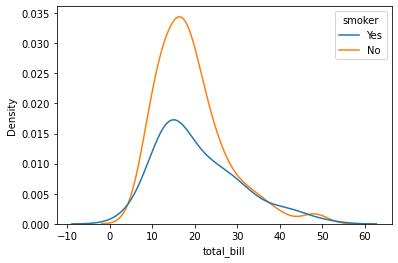

In [ ]:
sns.kdeplot(data = tips, x = "total_bill", hue = 'smoker')

In [ ]:
tips

total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]

dict_keys(['100669', '220962', '538363', '720193', '745224', '395129', '776328', '579284', '841866', '622852', '785899', '962159', '796581', '799296', '808022', '248252', '261313', '326223', '431312', '527796', '553321', '594887', '621276', '710707', '751131', '763813', '803262', '862649', '879155', '892687', '937904', '973891', '984799', '171538', '264325', '398248', '405035', '540641', '865881', '893198', '201848', '525584', '588087', '657486', '733568', '856401', '872895', '186676', '342329', '554303', '913228', '998757', '240168', '256487', '698266', '863985', '980953', '219303', '180679', '336172', '277905', '352716', '151985', '257279', '207969', '366286', '278135', '218719', '539502', '526319', '368258', '556357', '501973', '472761', '489146', '396697', '561993', '389015', '663153', '717868', '693572', '737973', '675397', '578526', '733162', '777078', '785873', '827212', '771782', '865501', '815316', '986737', '918136', '923862', '893255', '897652', '876011', '990622', '966655',

In [ ]:
def make_df(data, user_key):
  header = ['25%_acc_x', '25%_acc_y', '25%_vel_x', 
            '25%_vel_y', '50%_acc_x', '50%_acc_y', 
            '50%_vel_x', '50%_vel_y', '75%_acc_x', 
            '75%_acc_y', '75%_vel_x', '75%_vel_y', 
            'acceleration', 'acceleration_percentile_25', 
            'acceleration_percentile_50', 'acceleration_percentile_75', 
            'area', 'avg_acc_x', 'avg_acc_y', 'avg_acceleration', 
            'avg_devs', 'avg_vel_x', 'avg_vel_y', 'avg_velocity', 
            'direction', 'displacement', 'duration', 'endX', 'endY', 
            'final_acceleration', 'final_speed', 'final_velocity', 
            'initial_acceleration', 'initial_speed', 'initial_velocity', 
            'length', 'max_devs', 'speed', 'speed_percentile_25', 'speed_percentile_50', 
            'speed_percentile_75', 'startX', 'startY', 'velocity', 'velocity_percentile_25', 
            'velocity_percentile_50', 'velocity_percentile_75']
  new_header = []
  for i in range(5):
    for j in header:
      new_header.append(j + "_" + str(i + 1))
  
  legit = data[user_key]
  adversary = []
  for i in data:
    if i == user_key:
      continue
    r = np.random.choice(len(data[i]), size = min(30, len(data[i])), replace = False)
    x = []
    for l in r:
      x.append(data[i][l])
    adversary.extend(x)
  df = pd.DataFrame(legit + adversary, columns=new_header)
  df['label'] = [0]*len(legit) + [1]*len(adversary)
  return df




IndentationError: ignored

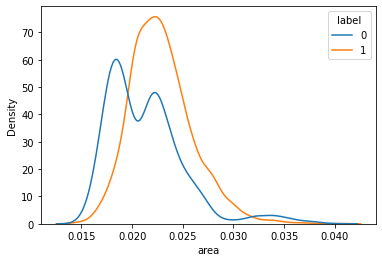

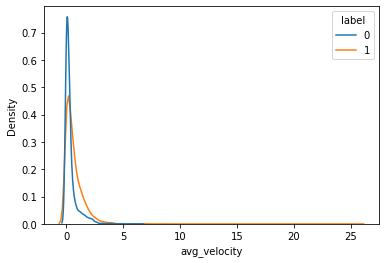

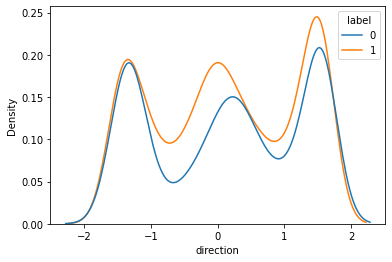

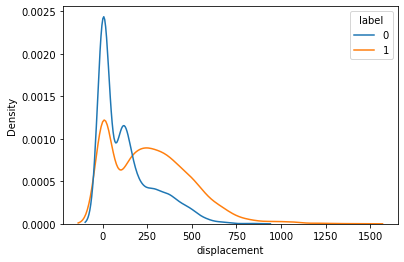

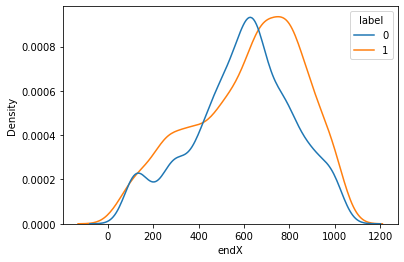

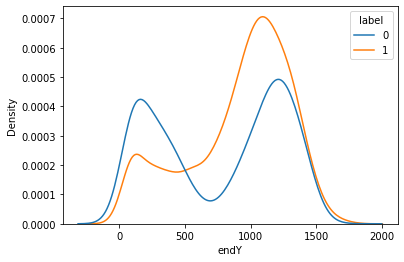

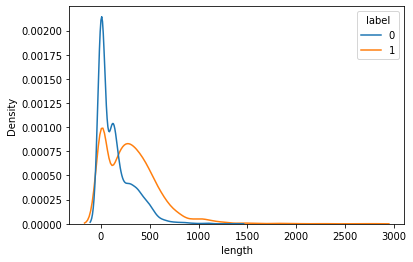

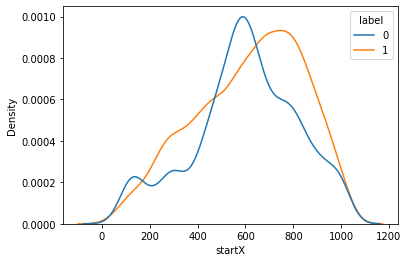

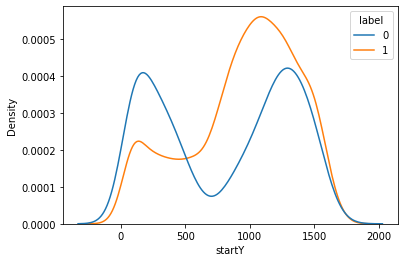

2


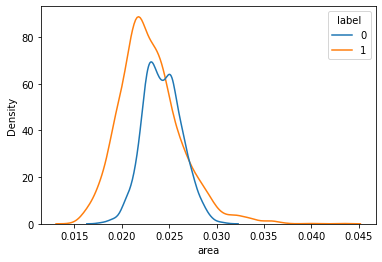

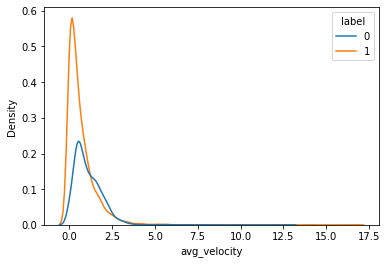

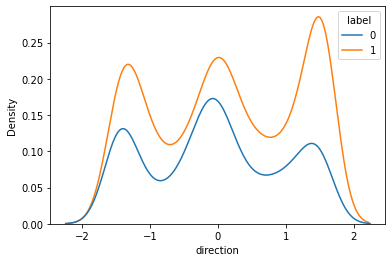

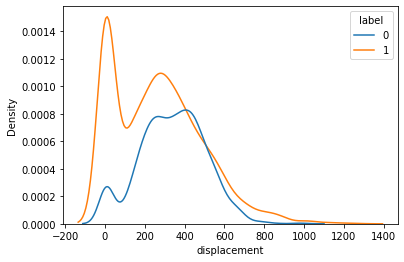

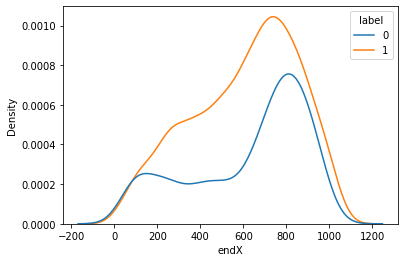

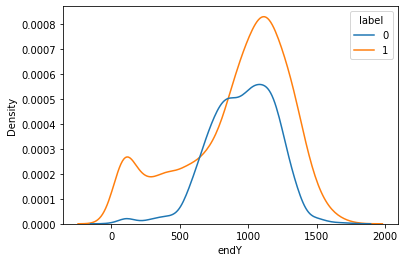

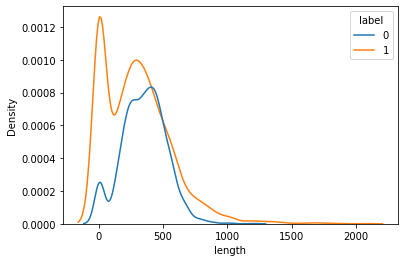

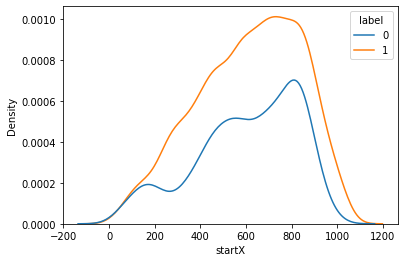

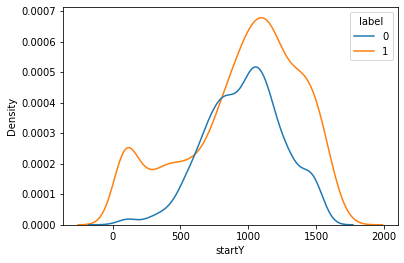

3


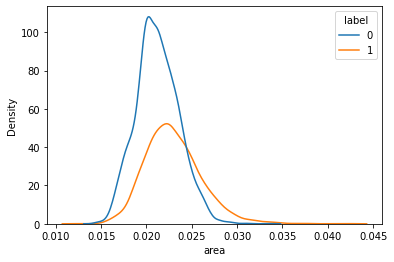

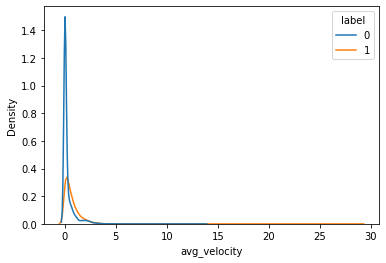

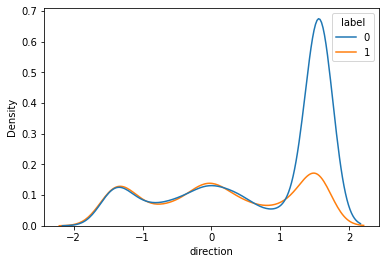

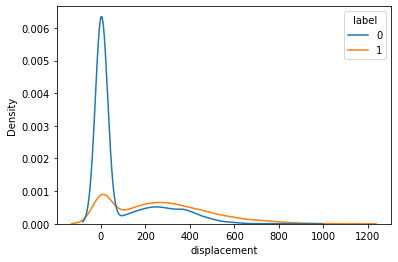

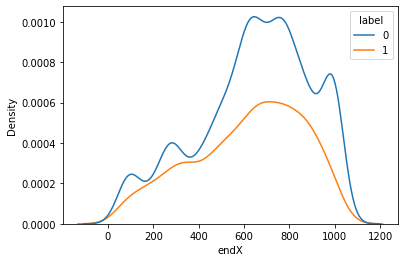

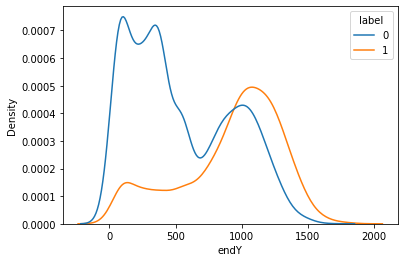

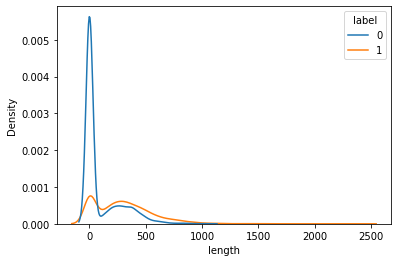

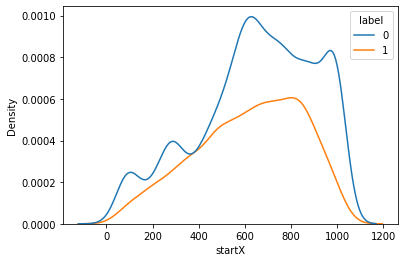

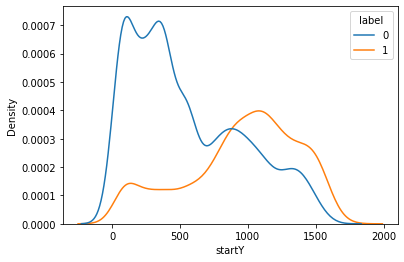

KeyboardInterrupt: ignored

In [ ]:

for i in h:
  df = make_df(h, i)
  for col in ['area', 'avg_velocity', 'direction', 'displacement', 'endX', 'endY', 'length', 'startX', 'startY']:
    if col == 'label':
      continue
    sns.kdeplot(data = df, x = col, hue = 'label')
    plt.show()
  input()

In [ ]:
f = "Pickle_Files_Swipe/Analyis/"

In [ ]:
adverGan = 'X_Adver_GAN_'
adverNonGan = 'X_Adver_NonGAN_'
legitGan = 'X_Legit_GAN_'
legitNonGan = 'X_Legit_NonGAN_'

In [ ]:
k = unpickling(f + adverGan + '1.pkl')

In [ ]:
k.shape

(457, 235)

In [ ]:
def plot_sns(user_key):
  header = ['25%_acc_x', '25%_acc_y', '25%_vel_x', 
            '25%_vel_y', '50%_acc_x', '50%_acc_y', 
            '50%_vel_x', '50%_vel_y', '75%_acc_x', 
            '75%_acc_y', '75%_vel_x', '75%_vel_y', 
            'acceleration', 'acceleration_percentile_25', 
            'acceleration_percentile_50', 'acceleration_percentile_75', 
            'area', 'avg_acc_x', 'avg_acc_y', 'avg_acceleration', 
            'avg_devs', 'avg_vel_x', 'avg_vel_y', 'avg_velocity', 
            'direction', 'displacement', 'duration', 'endX', 'endY', 
            'final_acceleration', 'final_speed', 'final_velocity', 
            'initial_acceleration', 'initial_speed', 'initial_velocity', 
            'length', 'max_devs', 'speed', 'speed_percentile_25', 'speed_percentile_50', 
            'speed_percentile_75', 'startX', 'startY', 'velocity', 'velocity_percentile_25', 
            'velocity_percentile_50', 'velocity_percentile_75']
  new_header = []
  for i in range(5):
    for j in header:
      new_header.append(j + "_" + str(i + 1))
  
  legit_gan = unpickling(f + legitGan + str(user_key) + ".pkl")
  legit_nongan = unpickling(f + legitNonGan + str(user_key) + '.pkl')[0]
  adver_gan = unpickling(f + adverGan + str(user_key) + ".pkl")
  adver_nongan = unpickling(f + adverNonGan + str(user_key) + ".pkl") [0]

  gan_df = pd.DataFrame(np.concatenate((legit_gan, adver_gan), axis = 0), columns = new_header)
  nongan_df = pd.DataFrame(np.concatenate((legit_nongan, adver_nongan), axis = 0), columns = new_header)

  gan_df['label'] = ['legit']*legit_gan.shape[0] + ['adversary']*adver_gan.shape[0]
  nongan_df['label'] = ['legit']*legit_nongan.shape[0] + ['adversary']*adver_nongan.shape[0]

  for i in new_header:
    if i == 'label':
      continue
    fig, ax = plt.subplots(1, 2)
    sns.kdeplot(data = nongan_df, x = i, hue = 'label', ax = ax[0])
    sns.kdeplot(data = gan_df, x = i, hue = 'label', ax = ax[1])
    plt.show()
    plt.clf()
  

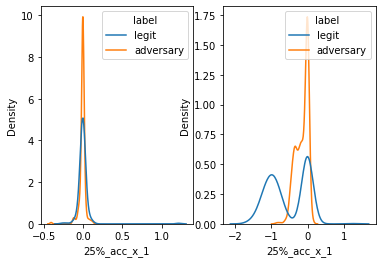

<Figure size 432x288 with 0 Axes>

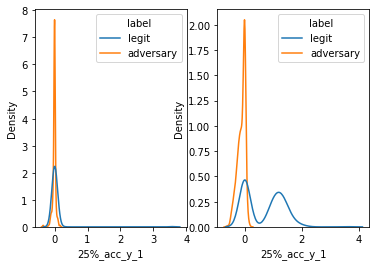

<Figure size 432x288 with 0 Axes>

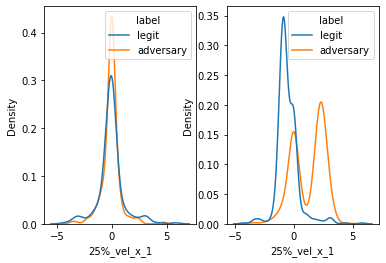

<Figure size 432x288 with 0 Axes>

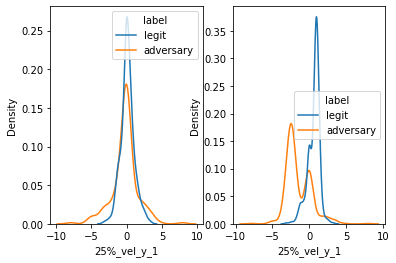

<Figure size 432x288 with 0 Axes>

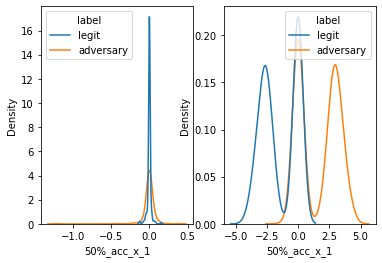

<Figure size 432x288 with 0 Axes>

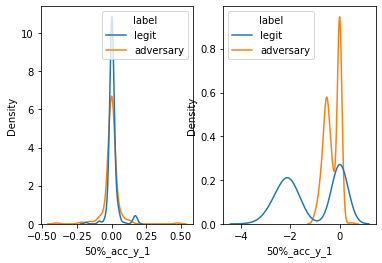

<Figure size 432x288 with 0 Axes>

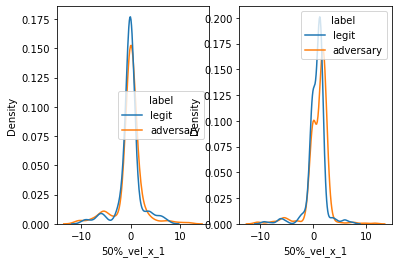

<Figure size 432x288 with 0 Axes>

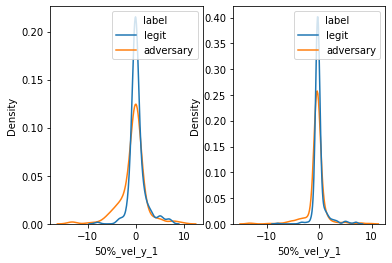

<Figure size 432x288 with 0 Axes>

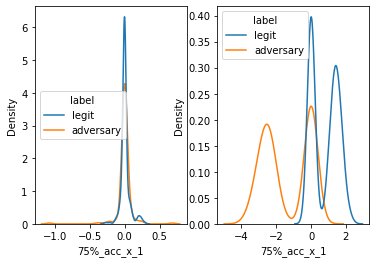

<Figure size 432x288 with 0 Axes>

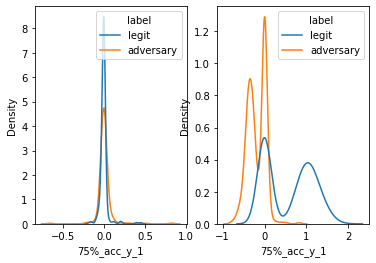

<Figure size 432x288 with 0 Axes>

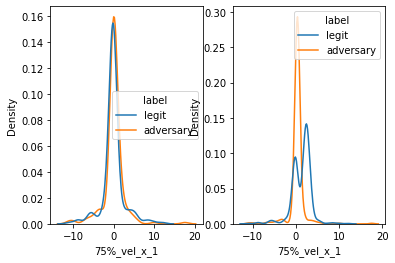

<Figure size 432x288 with 0 Axes>

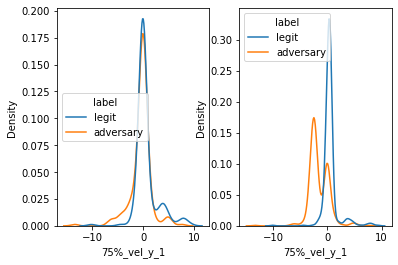

<Figure size 432x288 with 0 Axes>

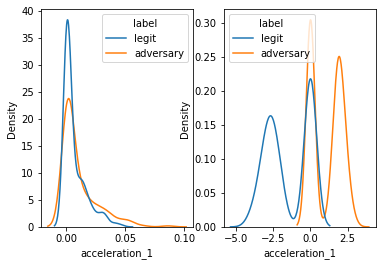

<Figure size 432x288 with 0 Axes>

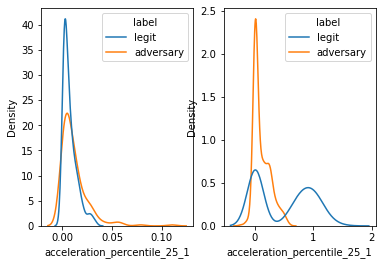

<Figure size 432x288 with 0 Axes>

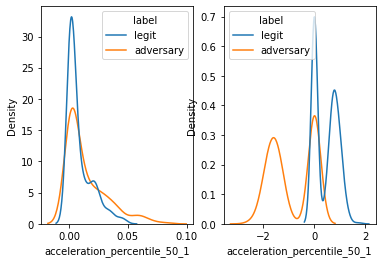

<Figure size 432x288 with 0 Axes>

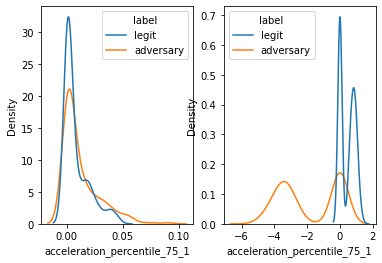

<Figure size 432x288 with 0 Axes>

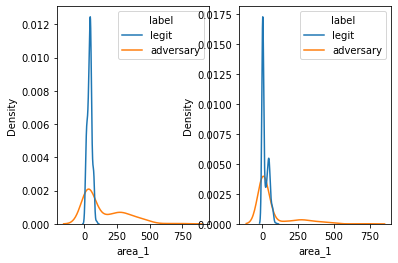

<Figure size 432x288 with 0 Axes>

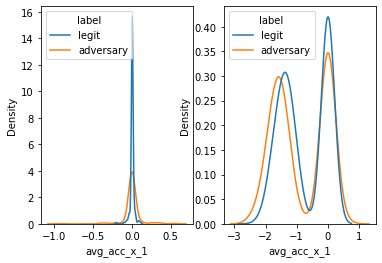

<Figure size 432x288 with 0 Axes>

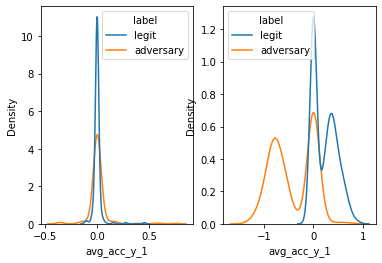

<Figure size 432x288 with 0 Axes>

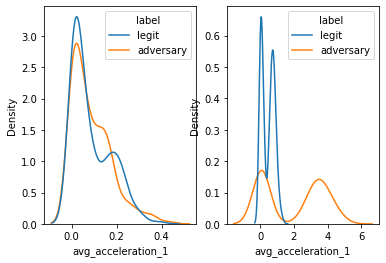

<Figure size 432x288 with 0 Axes>

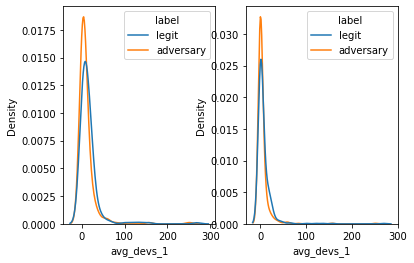

<Figure size 432x288 with 0 Axes>

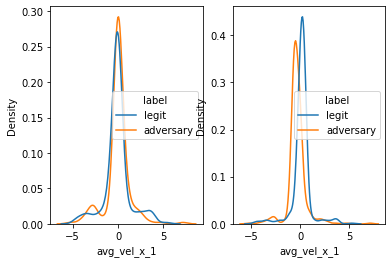

<Figure size 432x288 with 0 Axes>

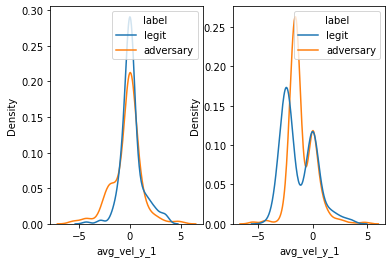

<Figure size 432x288 with 0 Axes>

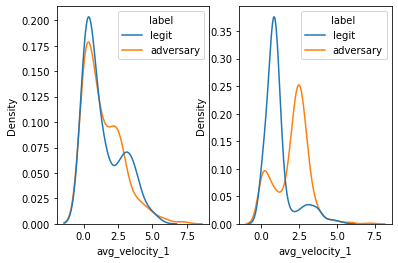

<Figure size 432x288 with 0 Axes>

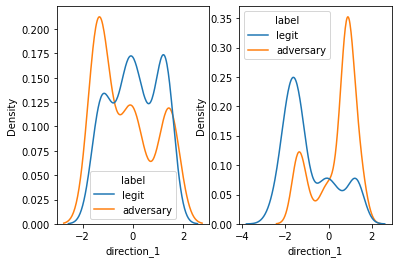

<Figure size 432x288 with 0 Axes>

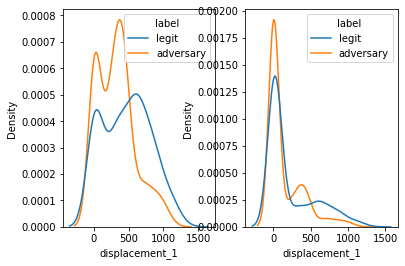

<Figure size 432x288 with 0 Axes>

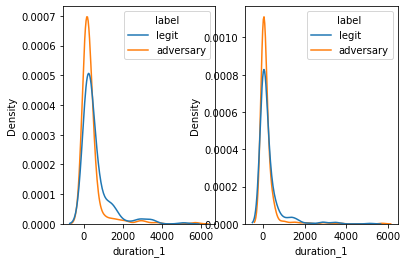

<Figure size 432x288 with 0 Axes>

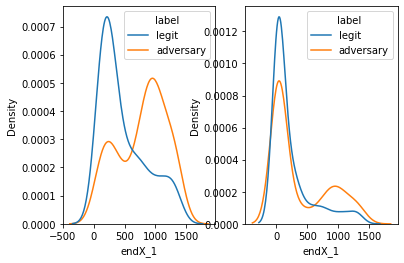

<Figure size 432x288 with 0 Axes>

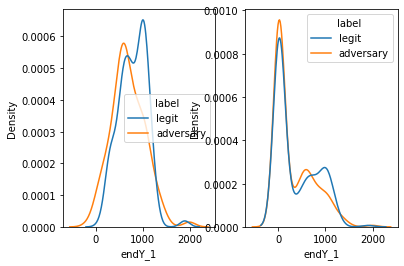

<Figure size 432x288 with 0 Axes>

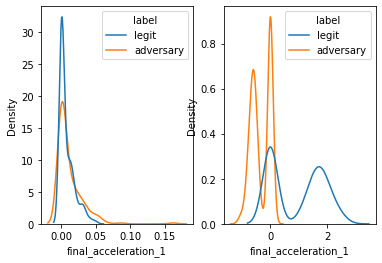

<Figure size 432x288 with 0 Axes>

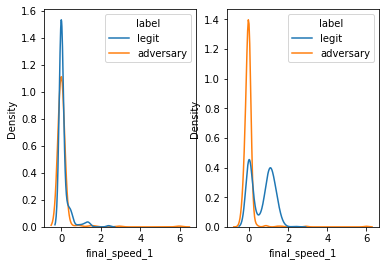

<Figure size 432x288 with 0 Axes>

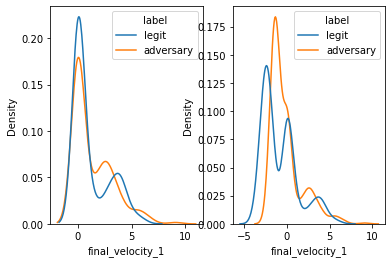

<Figure size 432x288 with 0 Axes>

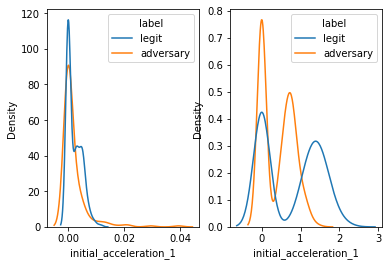

<Figure size 432x288 with 0 Axes>

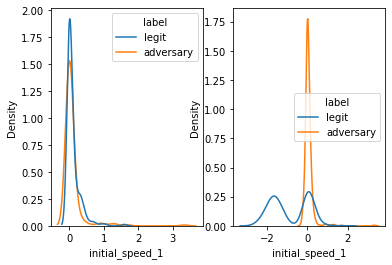

<Figure size 432x288 with 0 Axes>

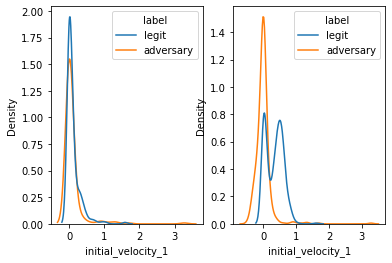

<Figure size 432x288 with 0 Axes>

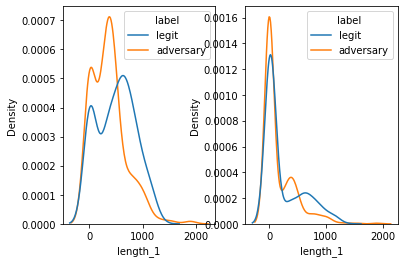

<Figure size 432x288 with 0 Axes>

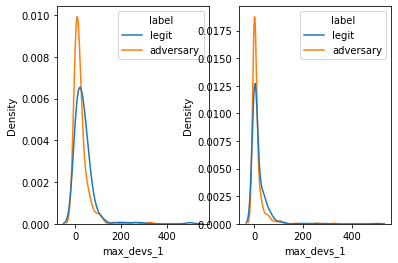

<Figure size 432x288 with 0 Axes>

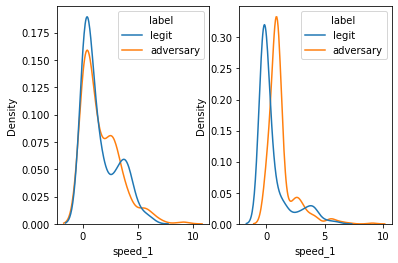

<Figure size 432x288 with 0 Axes>

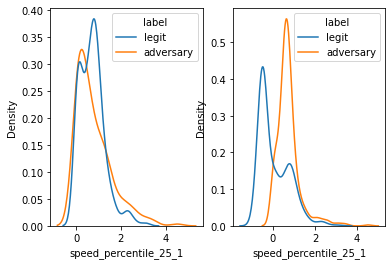

<Figure size 432x288 with 0 Axes>

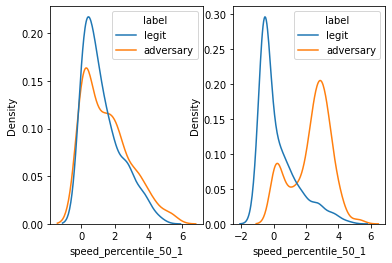

<Figure size 432x288 with 0 Axes>

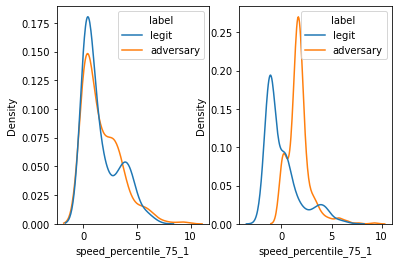

<Figure size 432x288 with 0 Axes>

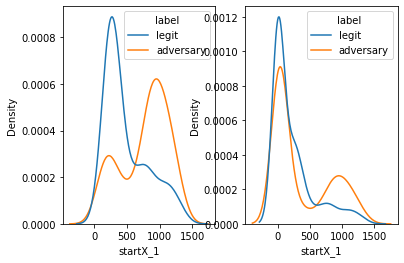

<Figure size 432x288 with 0 Axes>

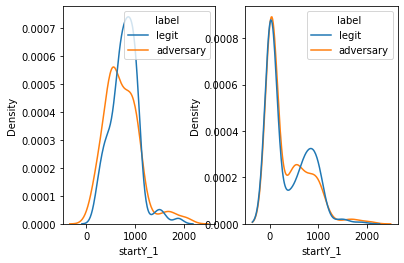

<Figure size 432x288 with 0 Axes>

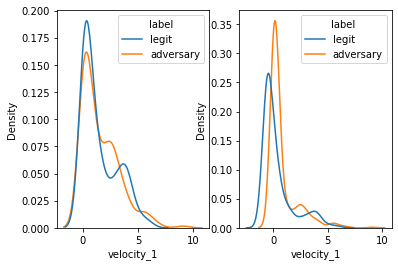

<Figure size 432x288 with 0 Axes>

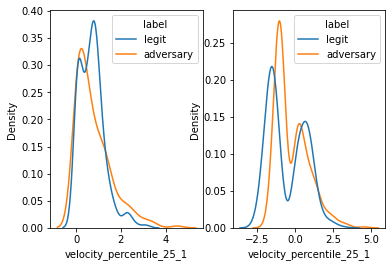

<Figure size 432x288 with 0 Axes>

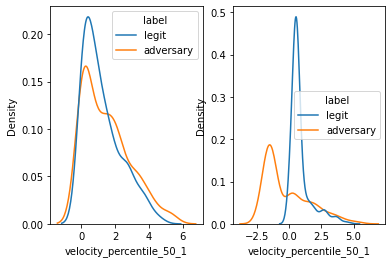

<Figure size 432x288 with 0 Axes>

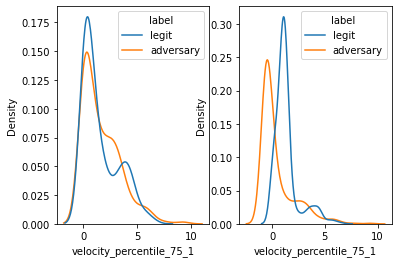

<Figure size 432x288 with 0 Axes>

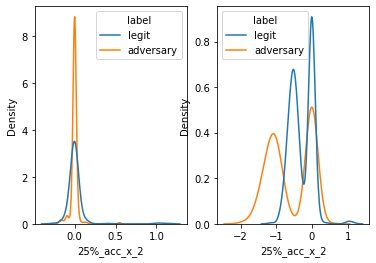

<Figure size 432x288 with 0 Axes>

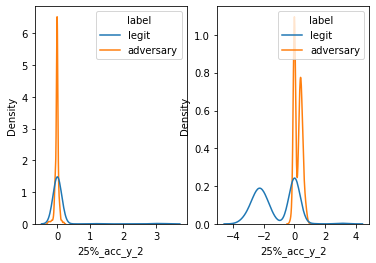

<Figure size 432x288 with 0 Axes>

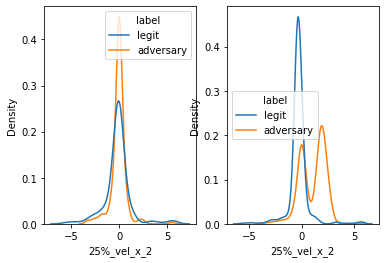

<Figure size 432x288 with 0 Axes>

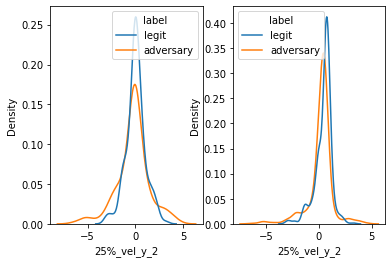

<Figure size 432x288 with 0 Axes>

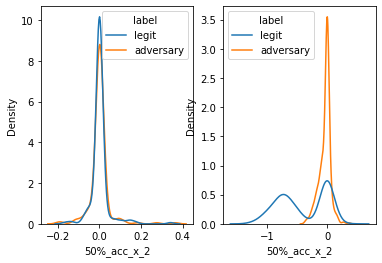

<Figure size 432x288 with 0 Axes>

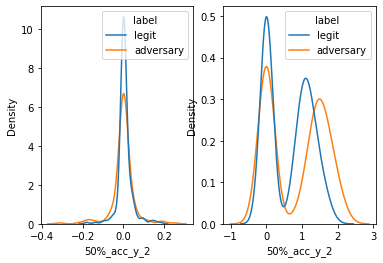

<Figure size 432x288 with 0 Axes>

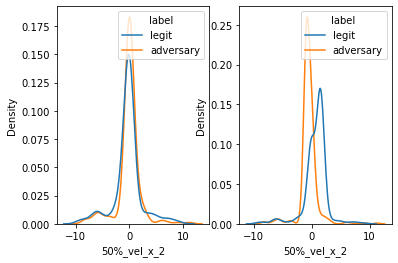

<Figure size 432x288 with 0 Axes>

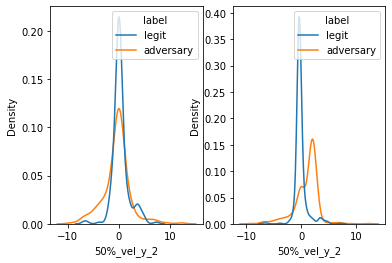

<Figure size 432x288 with 0 Axes>

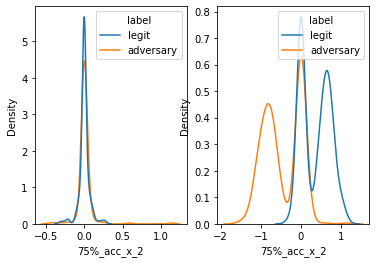

<Figure size 432x288 with 0 Axes>

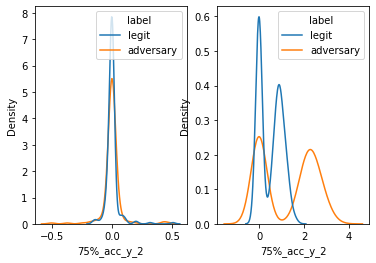

<Figure size 432x288 with 0 Axes>

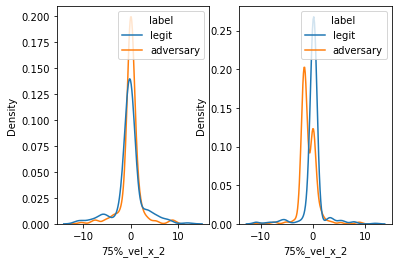

<Figure size 432x288 with 0 Axes>

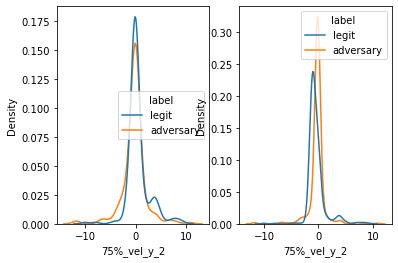

<Figure size 432x288 with 0 Axes>

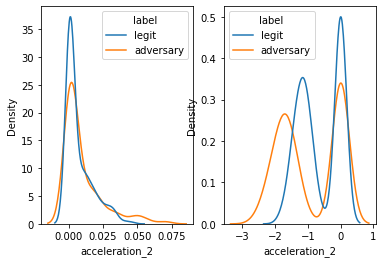

<Figure size 432x288 with 0 Axes>

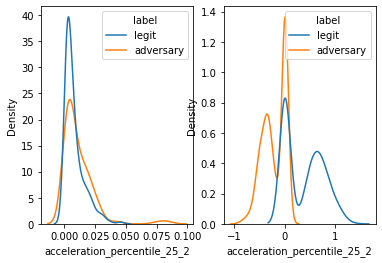

<Figure size 432x288 with 0 Axes>

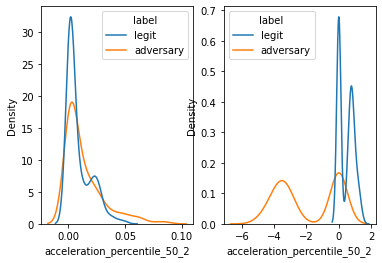

<Figure size 432x288 with 0 Axes>

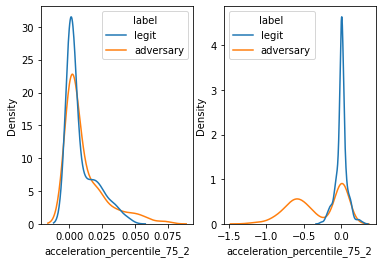

<Figure size 432x288 with 0 Axes>

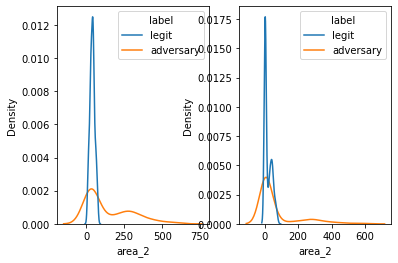

<Figure size 432x288 with 0 Axes>

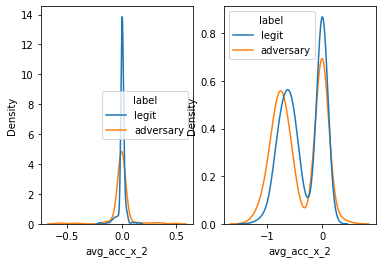

<Figure size 432x288 with 0 Axes>

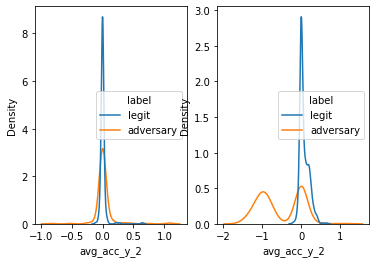

<Figure size 432x288 with 0 Axes>

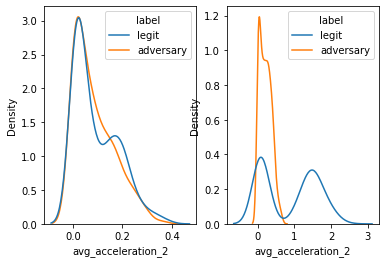

<Figure size 432x288 with 0 Axes>

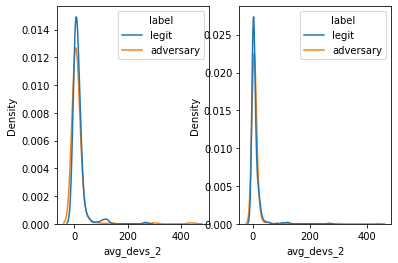

<Figure size 432x288 with 0 Axes>

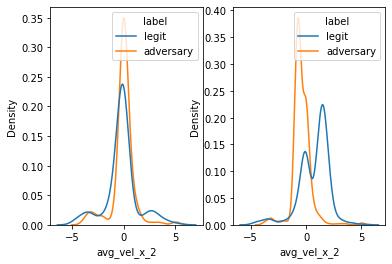

<Figure size 432x288 with 0 Axes>

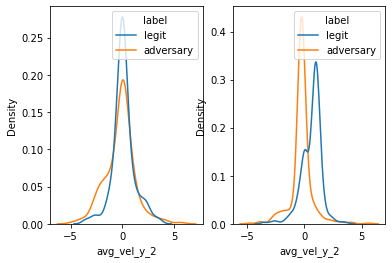

<Figure size 432x288 with 0 Axes>

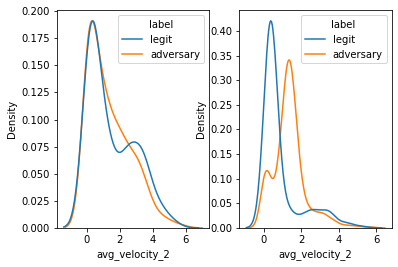

<Figure size 432x288 with 0 Axes>

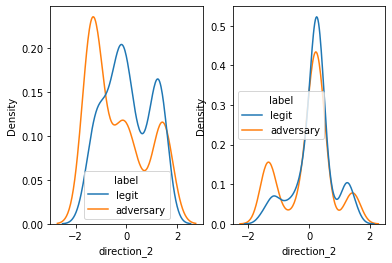

<Figure size 432x288 with 0 Axes>

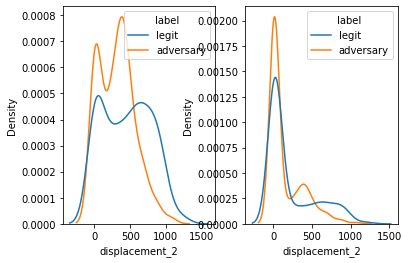

<Figure size 432x288 with 0 Axes>

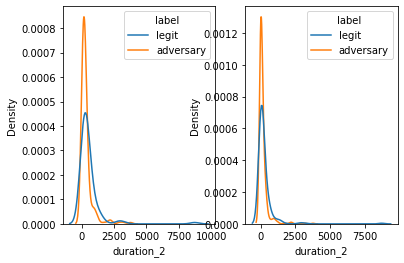

<Figure size 432x288 with 0 Axes>

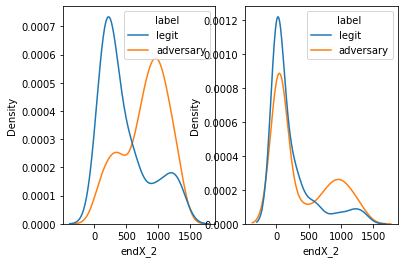

<Figure size 432x288 with 0 Axes>

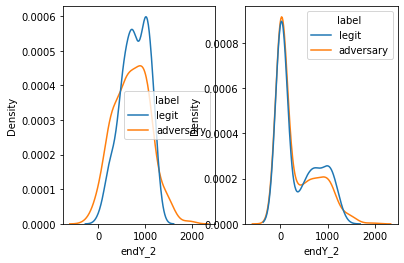

<Figure size 432x288 with 0 Axes>

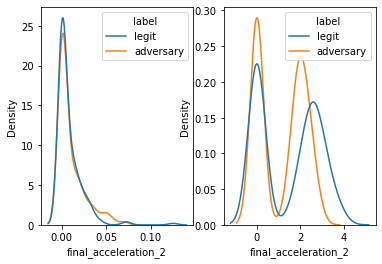

<Figure size 432x288 with 0 Axes>

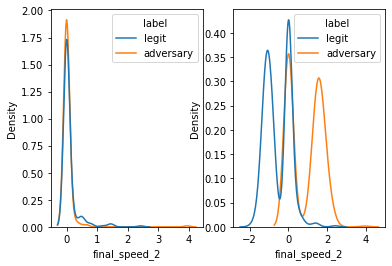

<Figure size 432x288 with 0 Axes>

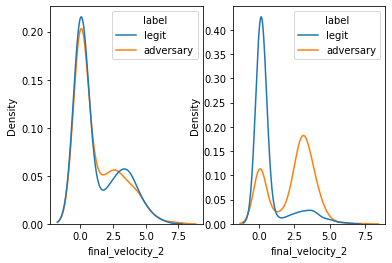

<Figure size 432x288 with 0 Axes>

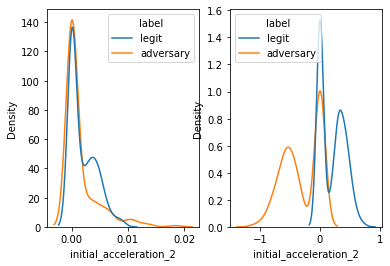

<Figure size 432x288 with 0 Axes>

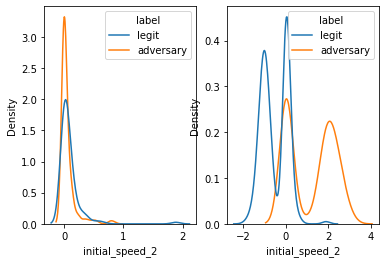

<Figure size 432x288 with 0 Axes>

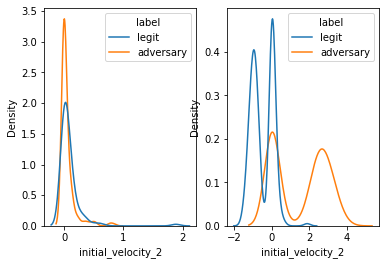

<Figure size 432x288 with 0 Axes>

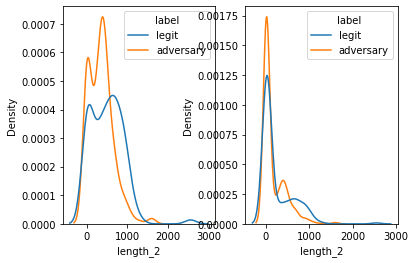

<Figure size 432x288 with 0 Axes>

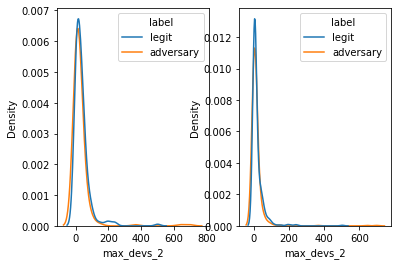

<Figure size 432x288 with 0 Axes>

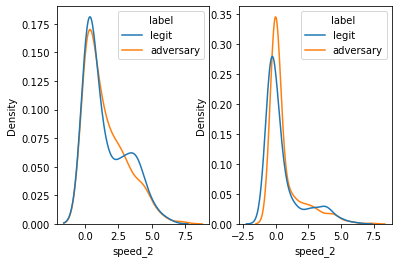

<Figure size 432x288 with 0 Axes>

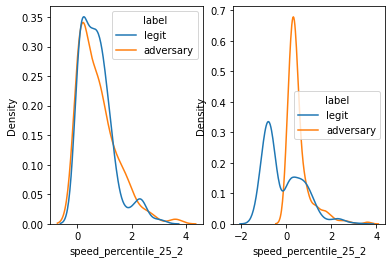

<Figure size 432x288 with 0 Axes>

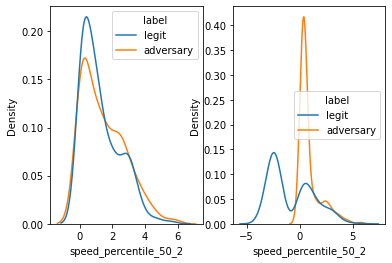

<Figure size 432x288 with 0 Axes>

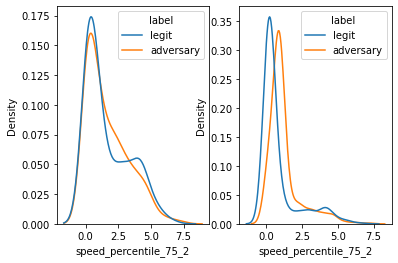

<Figure size 432x288 with 0 Axes>

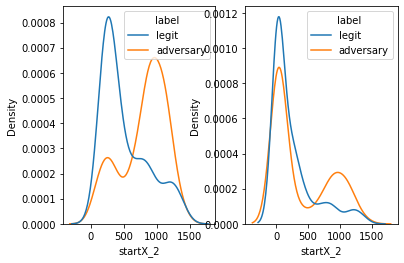

<Figure size 432x288 with 0 Axes>

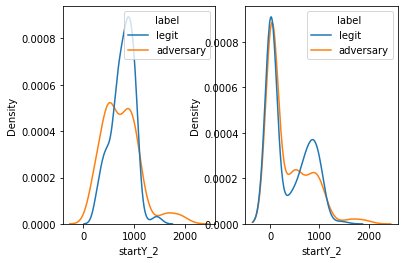

<Figure size 432x288 with 0 Axes>

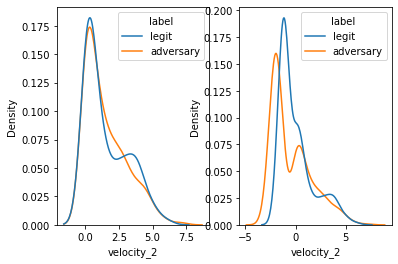

<Figure size 432x288 with 0 Axes>

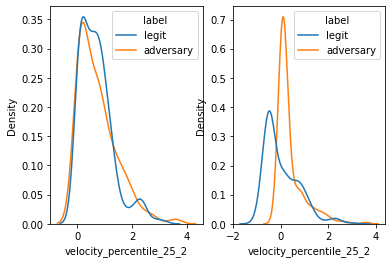

<Figure size 432x288 with 0 Axes>

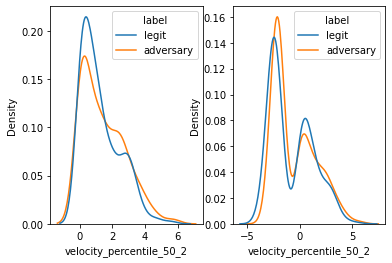

<Figure size 432x288 with 0 Axes>

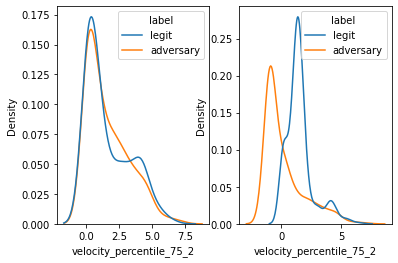

<Figure size 432x288 with 0 Axes>

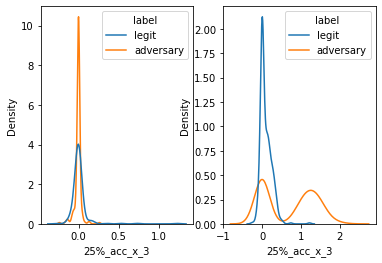

<Figure size 432x288 with 0 Axes>

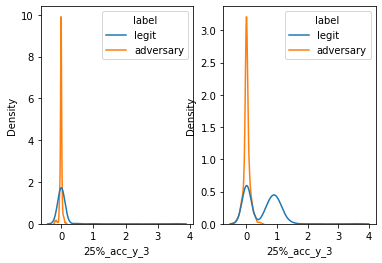

<Figure size 432x288 with 0 Axes>

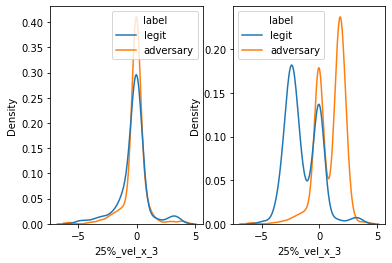

<Figure size 432x288 with 0 Axes>

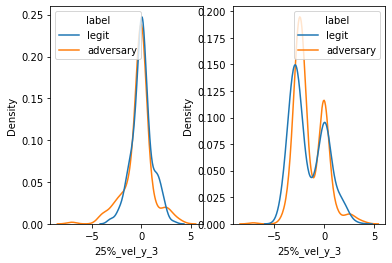

<Figure size 432x288 with 0 Axes>

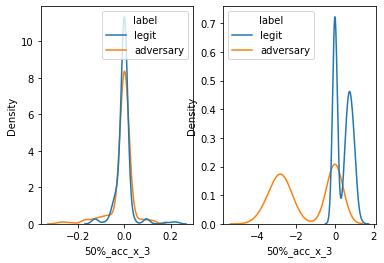

<Figure size 432x288 with 0 Axes>

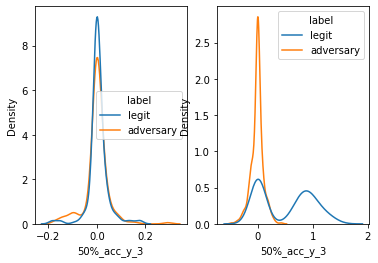

<Figure size 432x288 with 0 Axes>

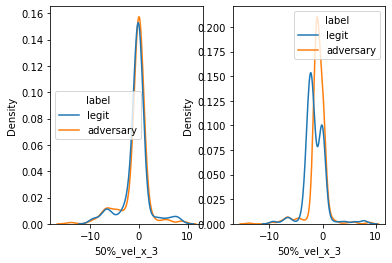

<Figure size 432x288 with 0 Axes>

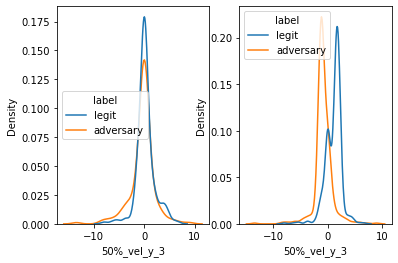

<Figure size 432x288 with 0 Axes>

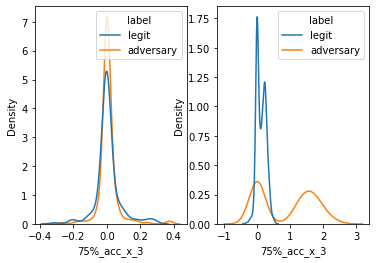

<Figure size 432x288 with 0 Axes>

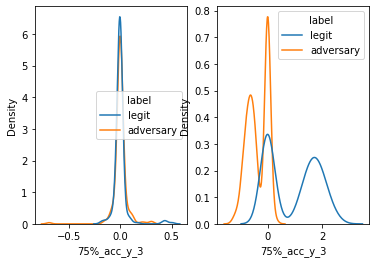

<Figure size 432x288 with 0 Axes>

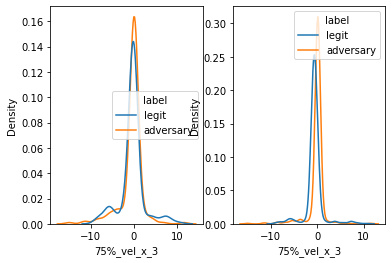

<Figure size 432x288 with 0 Axes>

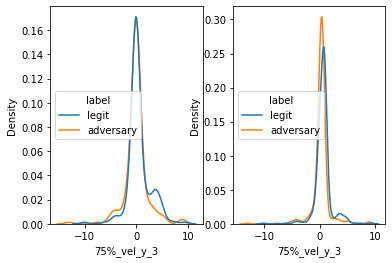

<Figure size 432x288 with 0 Axes>

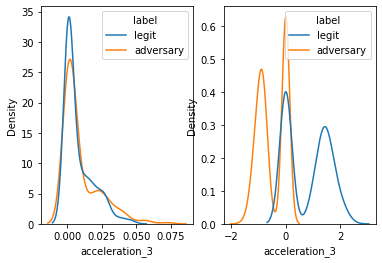

<Figure size 432x288 with 0 Axes>

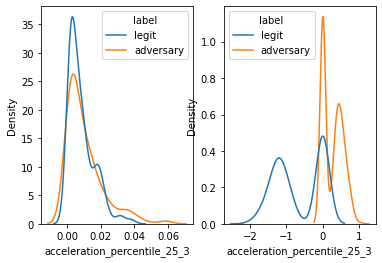

<Figure size 432x288 with 0 Axes>

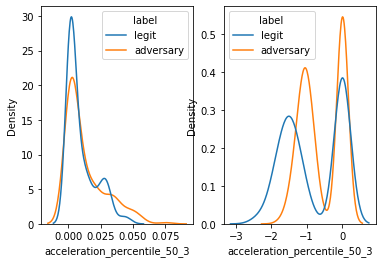

<Figure size 432x288 with 0 Axes>

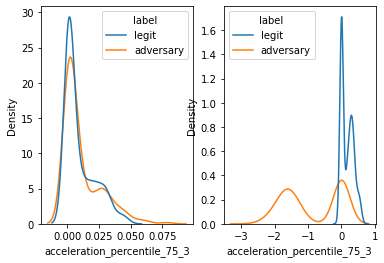

<Figure size 432x288 with 0 Axes>

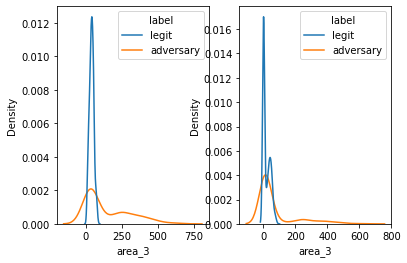

<Figure size 432x288 with 0 Axes>

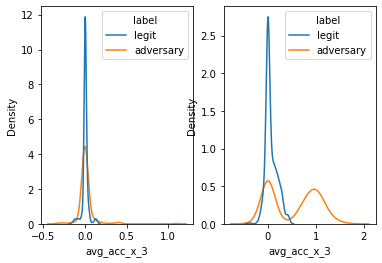

<Figure size 432x288 with 0 Axes>

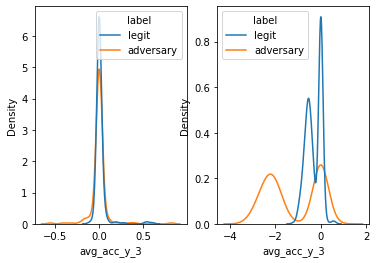

<Figure size 432x288 with 0 Axes>

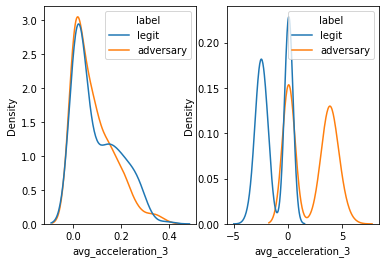

<Figure size 432x288 with 0 Axes>

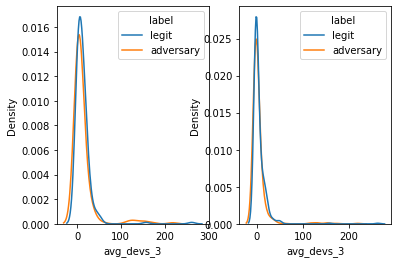

<Figure size 432x288 with 0 Axes>

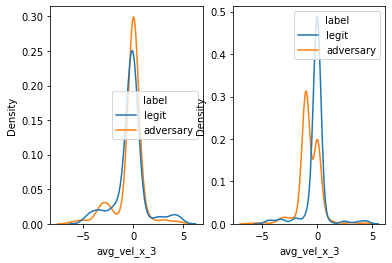

<Figure size 432x288 with 0 Axes>

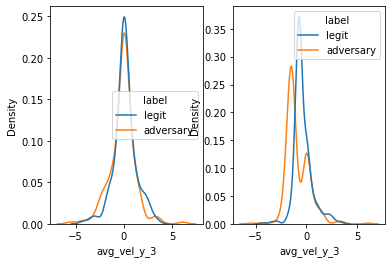

<Figure size 432x288 with 0 Axes>

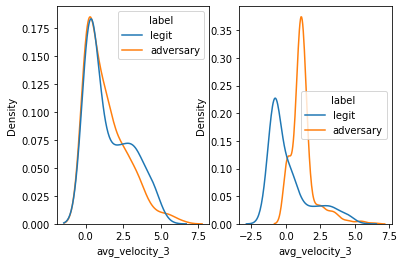

<Figure size 432x288 with 0 Axes>

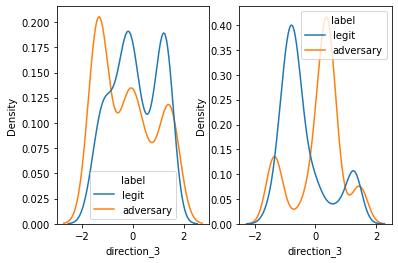

<Figure size 432x288 with 0 Axes>

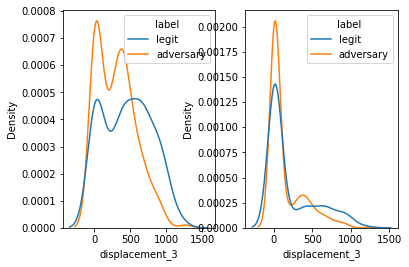

<Figure size 432x288 with 0 Axes>

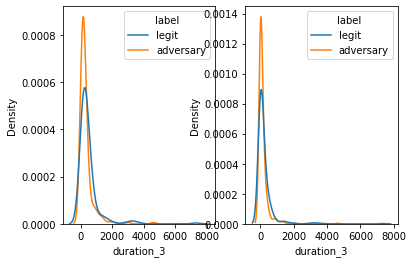

<Figure size 432x288 with 0 Axes>

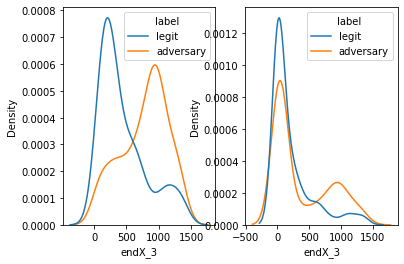

<Figure size 432x288 with 0 Axes>

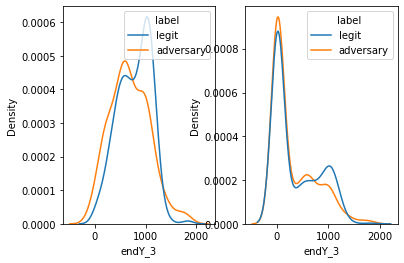

<Figure size 432x288 with 0 Axes>

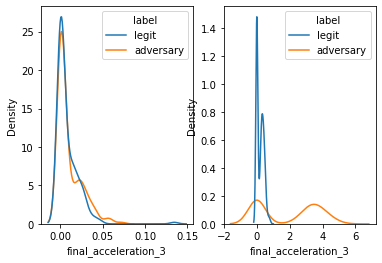

<Figure size 432x288 with 0 Axes>

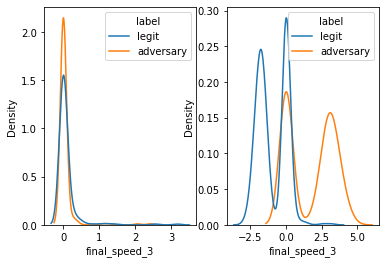

<Figure size 432x288 with 0 Axes>

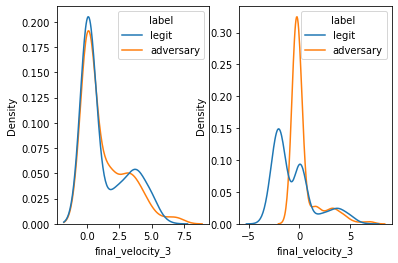

<Figure size 432x288 with 0 Axes>

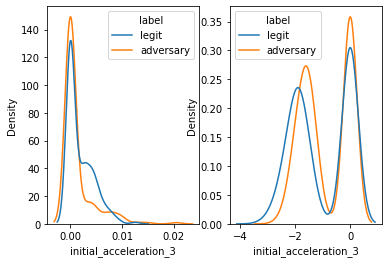

<Figure size 432x288 with 0 Axes>

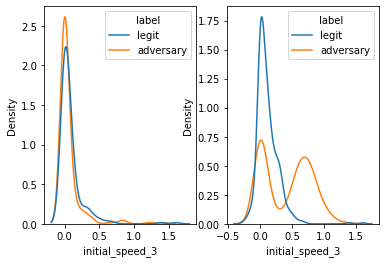

<Figure size 432x288 with 0 Axes>

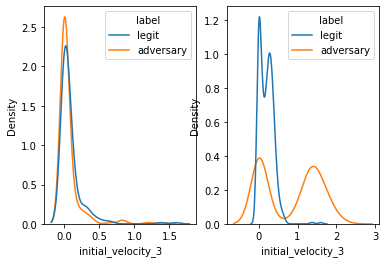

<Figure size 432x288 with 0 Axes>

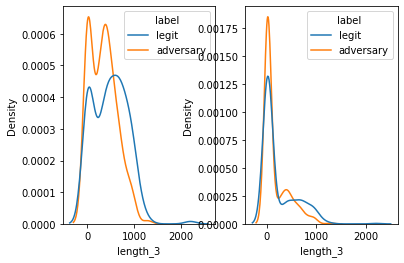

<Figure size 432x288 with 0 Axes>

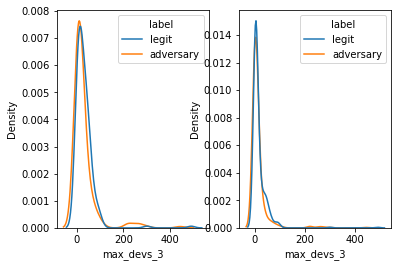

<Figure size 432x288 with 0 Axes>

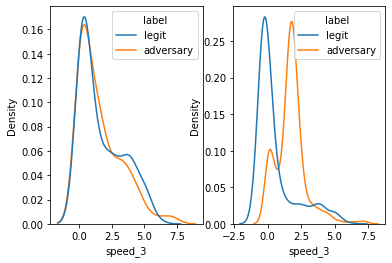

<Figure size 432x288 with 0 Axes>

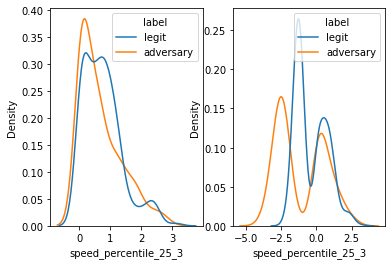

<Figure size 432x288 with 0 Axes>

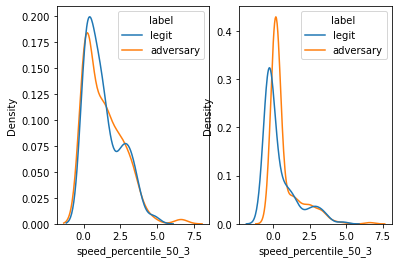

<Figure size 432x288 with 0 Axes>

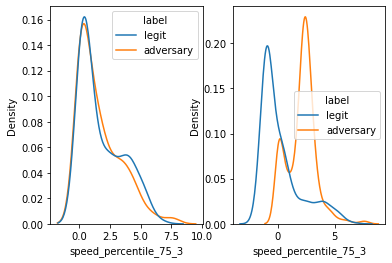

<Figure size 432x288 with 0 Axes>

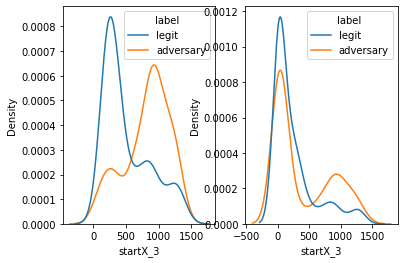

<Figure size 432x288 with 0 Axes>

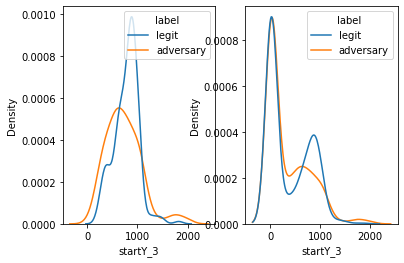

<Figure size 432x288 with 0 Axes>

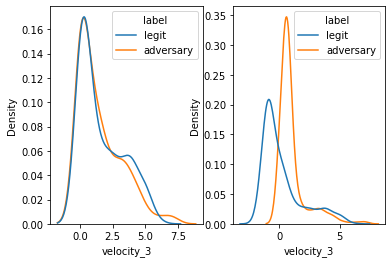

<Figure size 432x288 with 0 Axes>

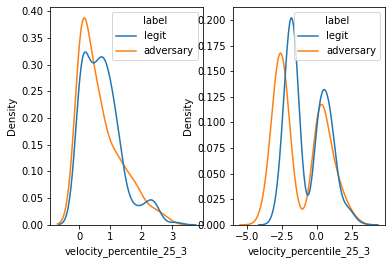

<Figure size 432x288 with 0 Axes>

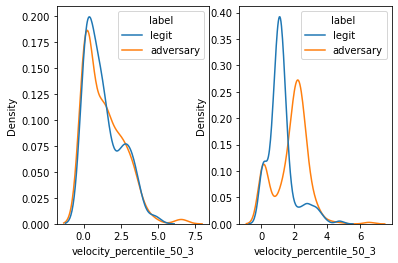

<Figure size 432x288 with 0 Axes>

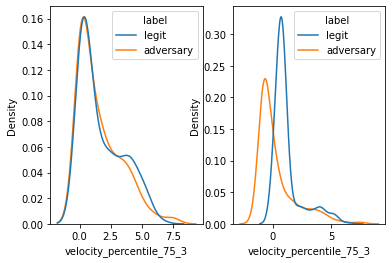

<Figure size 432x288 with 0 Axes>

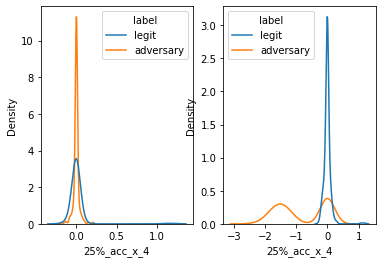

<Figure size 432x288 with 0 Axes>

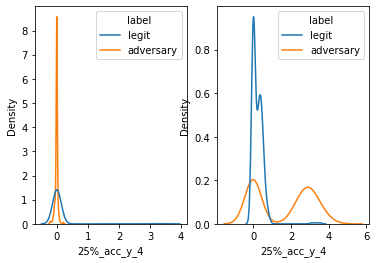

<Figure size 432x288 with 0 Axes>

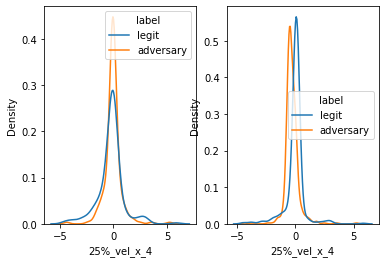

<Figure size 432x288 with 0 Axes>

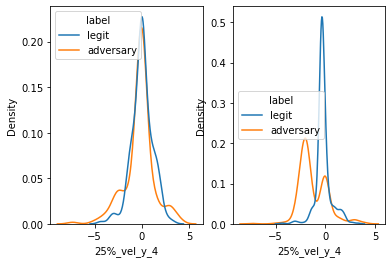

<Figure size 432x288 with 0 Axes>

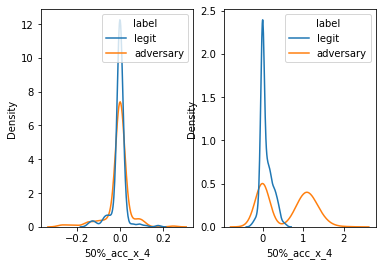

<Figure size 432x288 with 0 Axes>

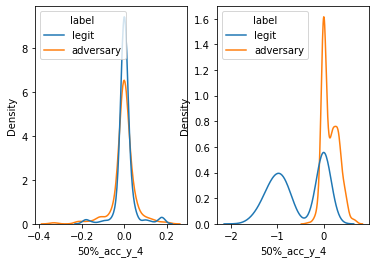

<Figure size 432x288 with 0 Axes>

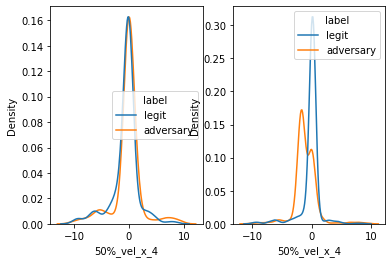

<Figure size 432x288 with 0 Axes>

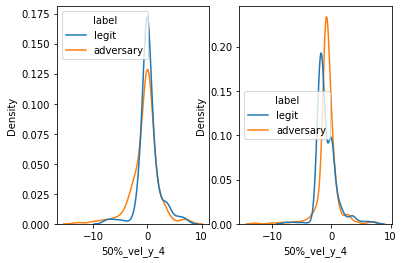

<Figure size 432x288 with 0 Axes>

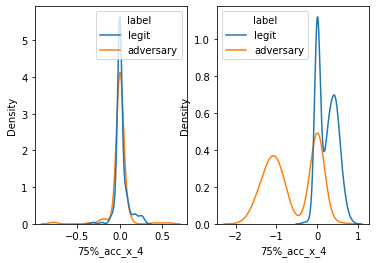

<Figure size 432x288 with 0 Axes>

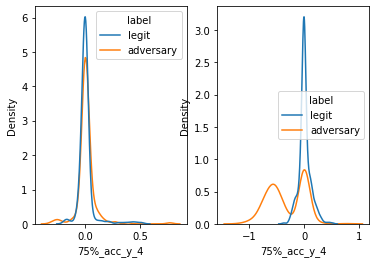

<Figure size 432x288 with 0 Axes>

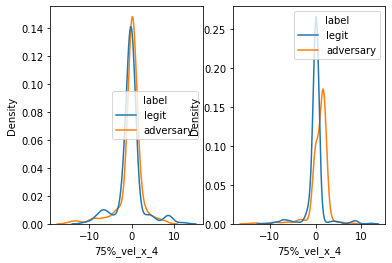

<Figure size 432x288 with 0 Axes>

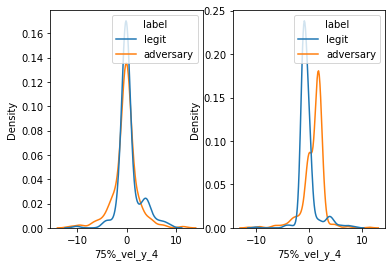

<Figure size 432x288 with 0 Axes>

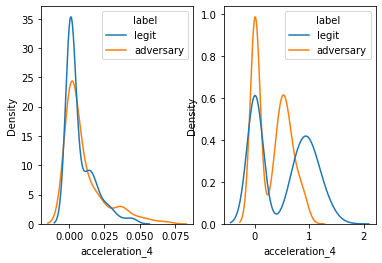

<Figure size 432x288 with 0 Axes>

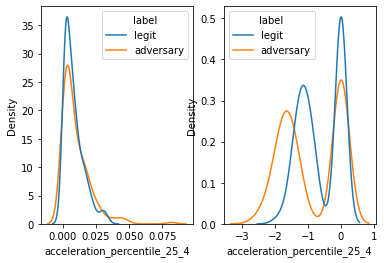

<Figure size 432x288 with 0 Axes>

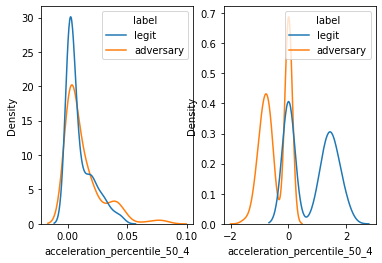

<Figure size 432x288 with 0 Axes>

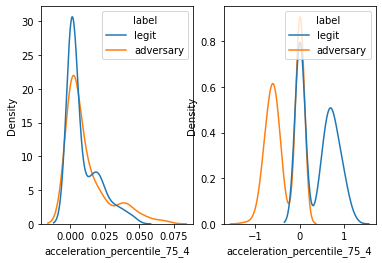

<Figure size 432x288 with 0 Axes>

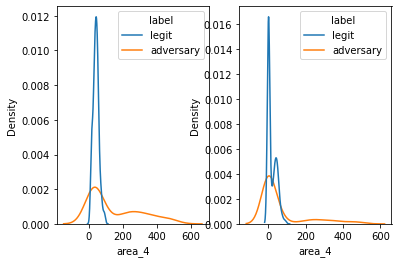

<Figure size 432x288 with 0 Axes>

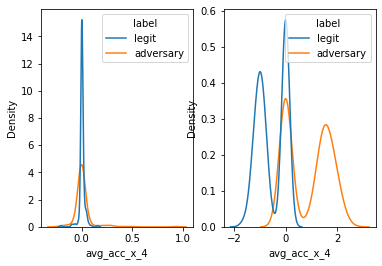

<Figure size 432x288 with 0 Axes>

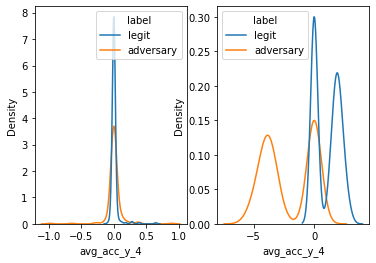

<Figure size 432x288 with 0 Axes>

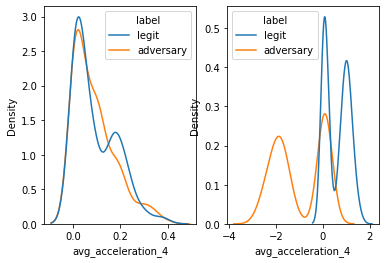

<Figure size 432x288 with 0 Axes>

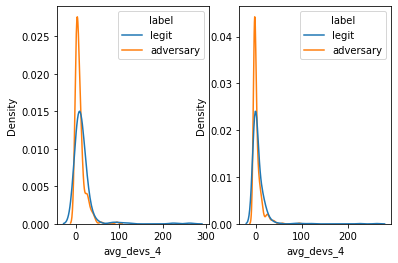

<Figure size 432x288 with 0 Axes>

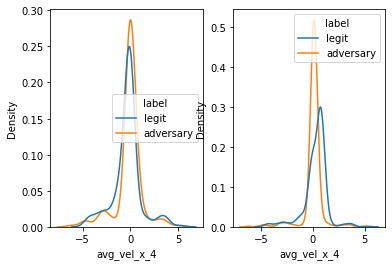

<Figure size 432x288 with 0 Axes>

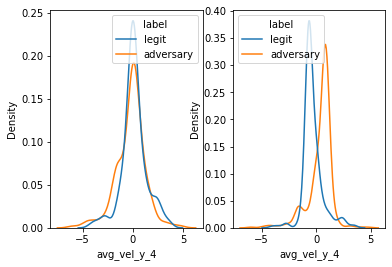

<Figure size 432x288 with 0 Axes>

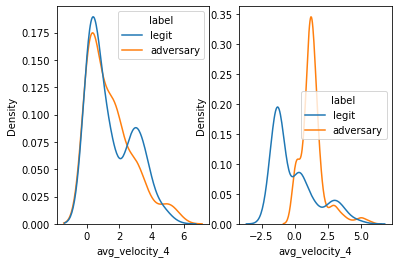

<Figure size 432x288 with 0 Axes>

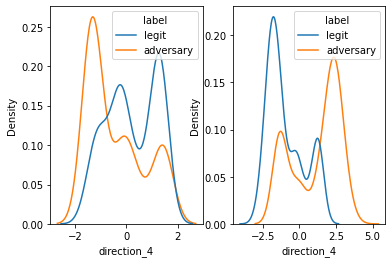

<Figure size 432x288 with 0 Axes>

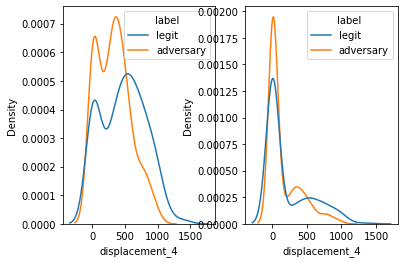

<Figure size 432x288 with 0 Axes>

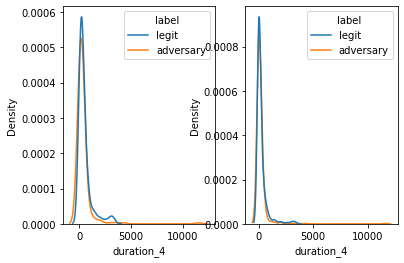

<Figure size 432x288 with 0 Axes>

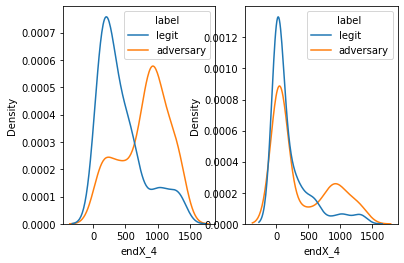

<Figure size 432x288 with 0 Axes>

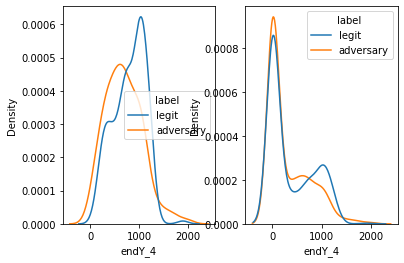

<Figure size 432x288 with 0 Axes>

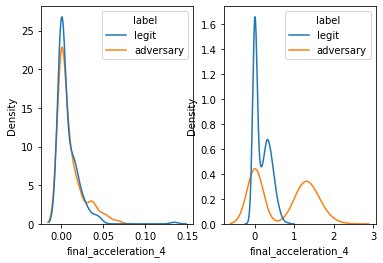

<Figure size 432x288 with 0 Axes>

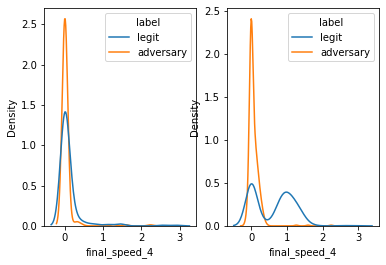

<Figure size 432x288 with 0 Axes>

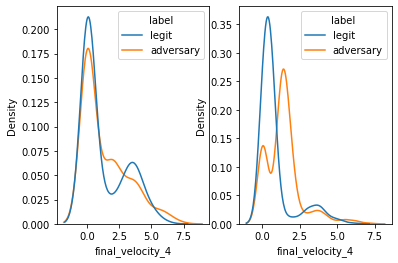

<Figure size 432x288 with 0 Axes>

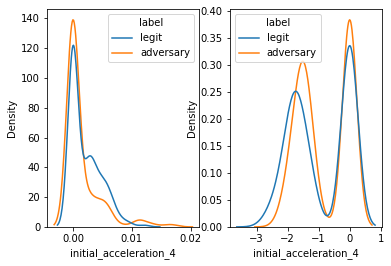

<Figure size 432x288 with 0 Axes>

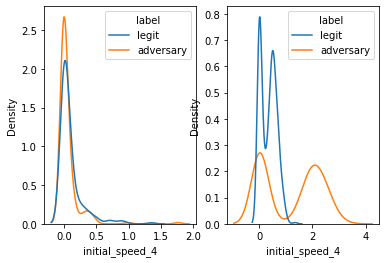

<Figure size 432x288 with 0 Axes>

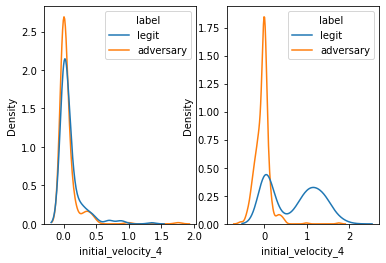

<Figure size 432x288 with 0 Axes>

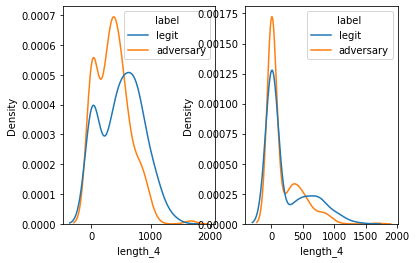

<Figure size 432x288 with 0 Axes>

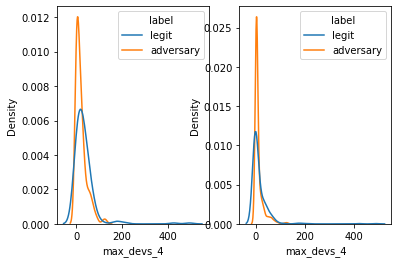

<Figure size 432x288 with 0 Axes>

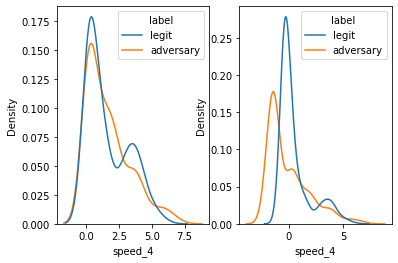

<Figure size 432x288 with 0 Axes>

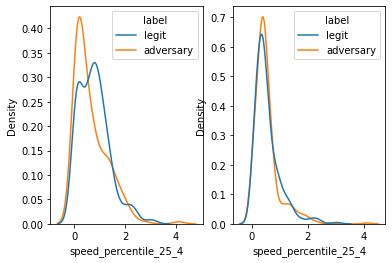

<Figure size 432x288 with 0 Axes>

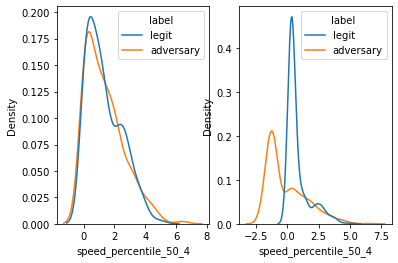

<Figure size 432x288 with 0 Axes>

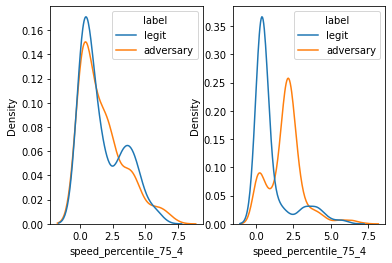

<Figure size 432x288 with 0 Axes>

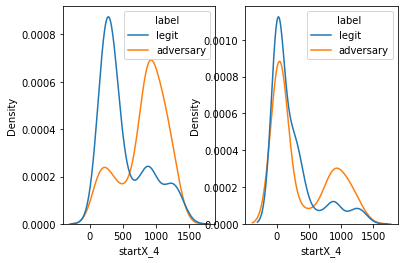

<Figure size 432x288 with 0 Axes>

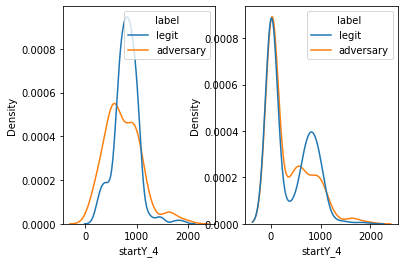

<Figure size 432x288 with 0 Axes>

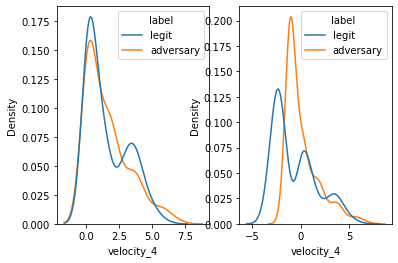

<Figure size 432x288 with 0 Axes>

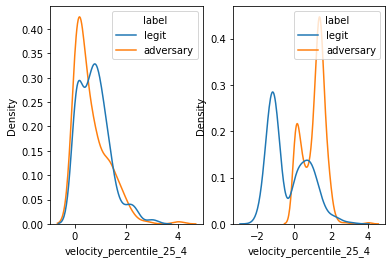

<Figure size 432x288 with 0 Axes>

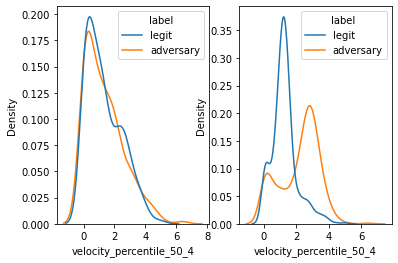

<Figure size 432x288 with 0 Axes>

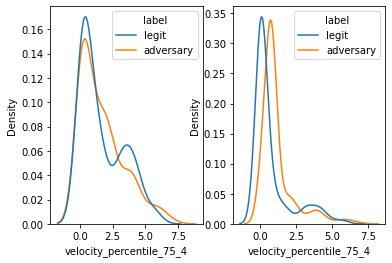

<Figure size 432x288 with 0 Axes>

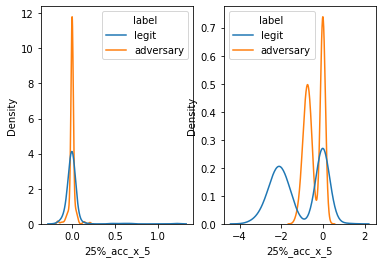

<Figure size 432x288 with 0 Axes>

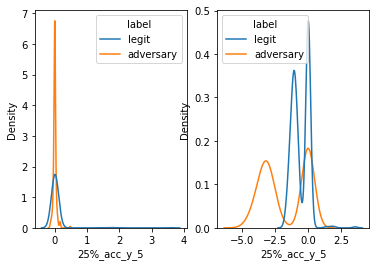

<Figure size 432x288 with 0 Axes>

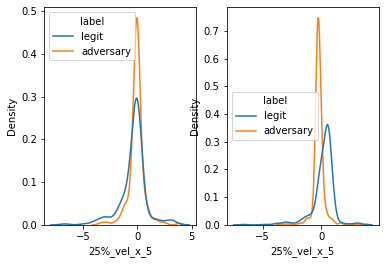

<Figure size 432x288 with 0 Axes>

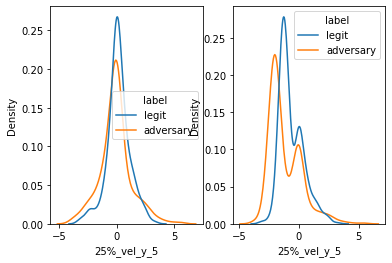

<Figure size 432x288 with 0 Axes>

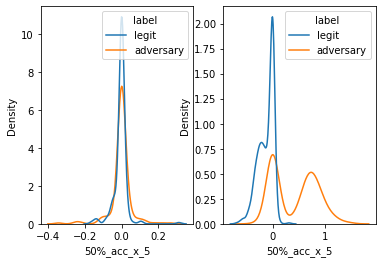

<Figure size 432x288 with 0 Axes>

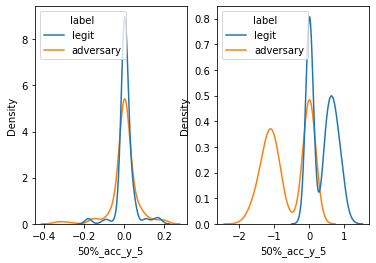

<Figure size 432x288 with 0 Axes>

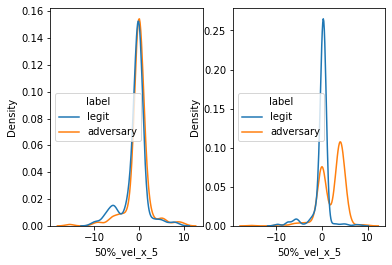

<Figure size 432x288 with 0 Axes>

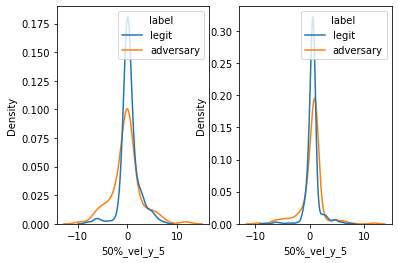

<Figure size 432x288 with 0 Axes>

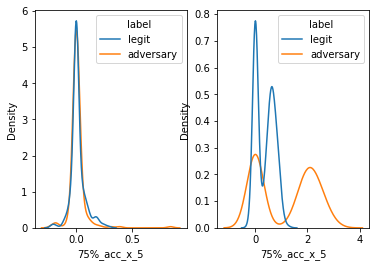

<Figure size 432x288 with 0 Axes>

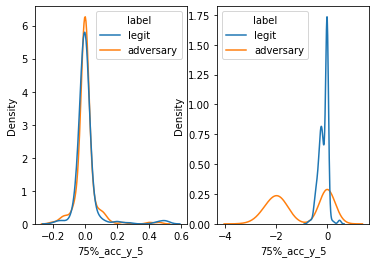

<Figure size 432x288 with 0 Axes>

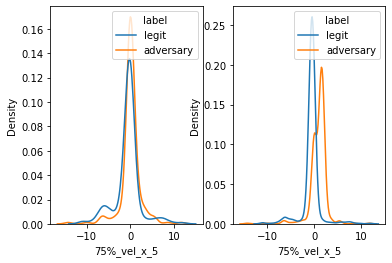

<Figure size 432x288 with 0 Axes>

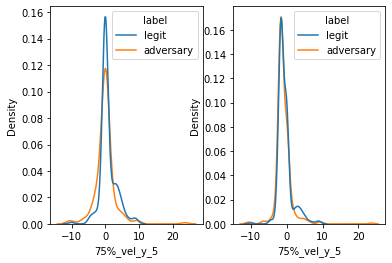

<Figure size 432x288 with 0 Axes>

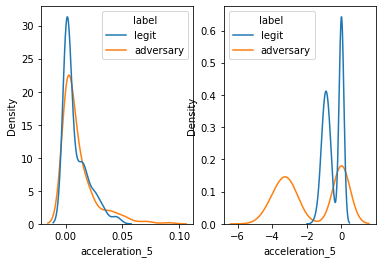

<Figure size 432x288 with 0 Axes>

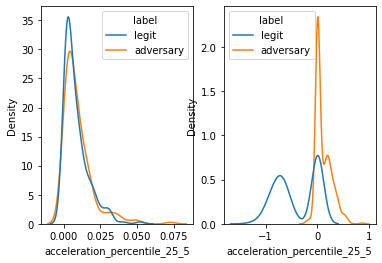

<Figure size 432x288 with 0 Axes>

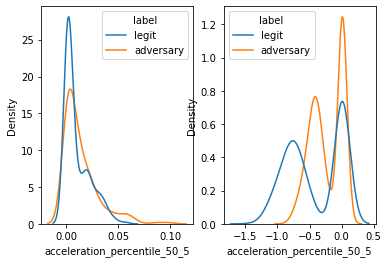

<Figure size 432x288 with 0 Axes>

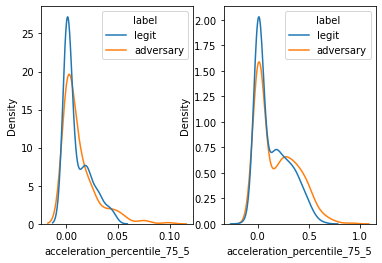

<Figure size 432x288 with 0 Axes>

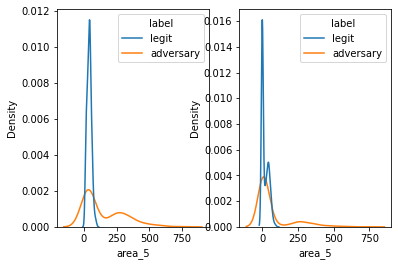

<Figure size 432x288 with 0 Axes>

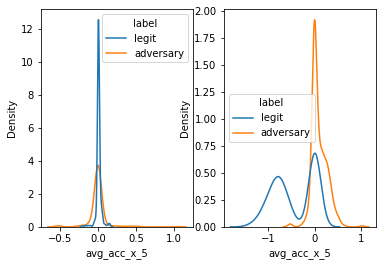

<Figure size 432x288 with 0 Axes>

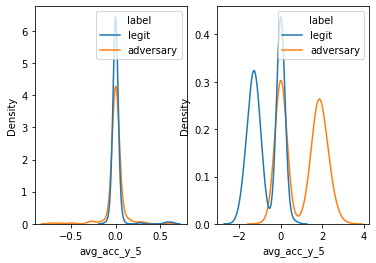

<Figure size 432x288 with 0 Axes>

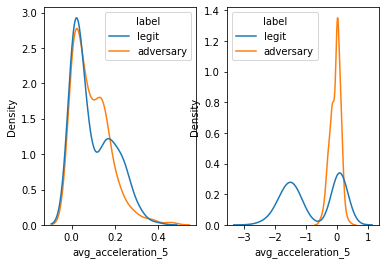

<Figure size 432x288 with 0 Axes>

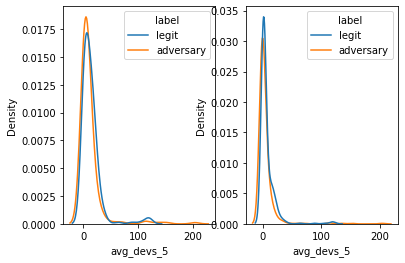

<Figure size 432x288 with 0 Axes>

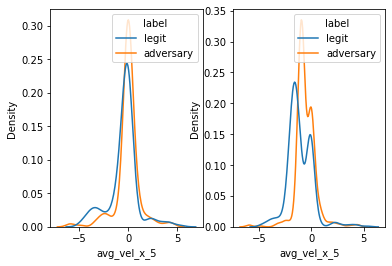

<Figure size 432x288 with 0 Axes>

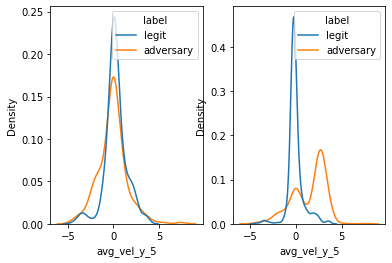

<Figure size 432x288 with 0 Axes>

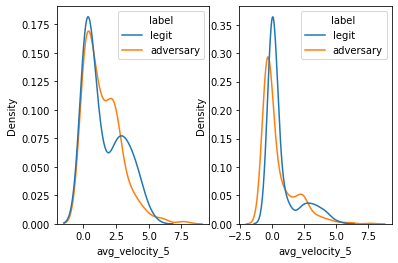

<Figure size 432x288 with 0 Axes>

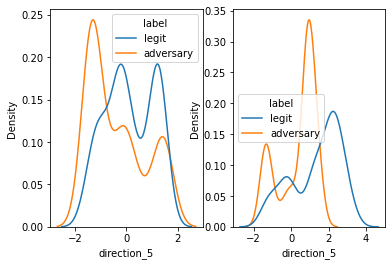

<Figure size 432x288 with 0 Axes>

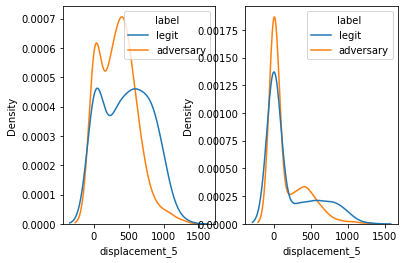

<Figure size 432x288 with 0 Axes>

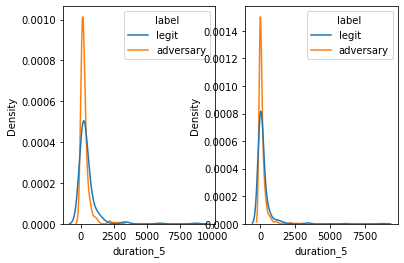

<Figure size 432x288 with 0 Axes>

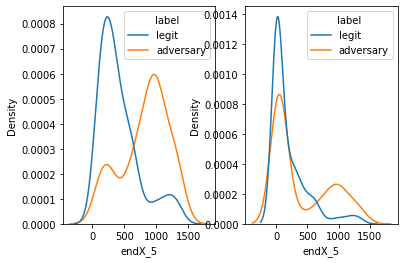

<Figure size 432x288 with 0 Axes>

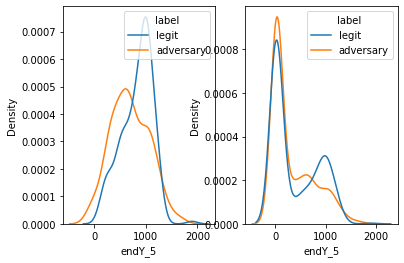

<Figure size 432x288 with 0 Axes>

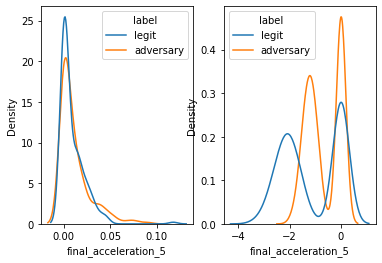

<Figure size 432x288 with 0 Axes>

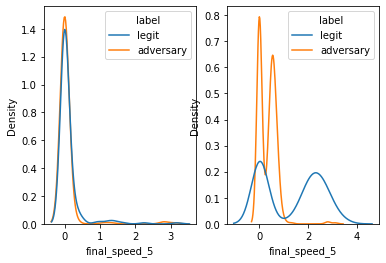

<Figure size 432x288 with 0 Axes>

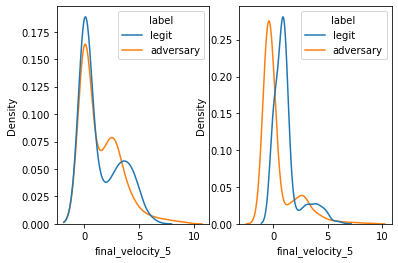

<Figure size 432x288 with 0 Axes>

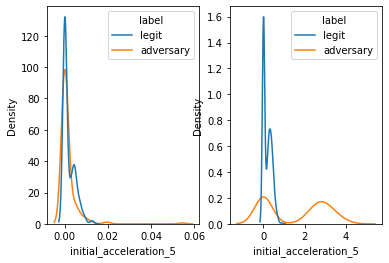

<Figure size 432x288 with 0 Axes>

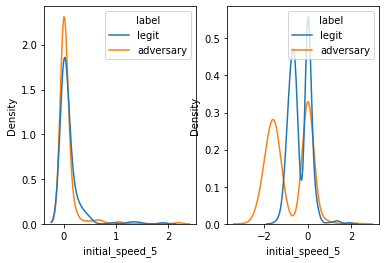

<Figure size 432x288 with 0 Axes>

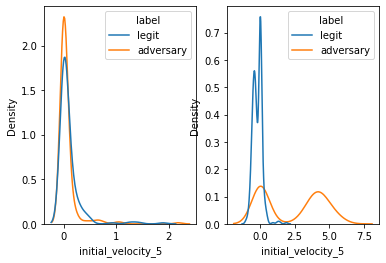

<Figure size 432x288 with 0 Axes>

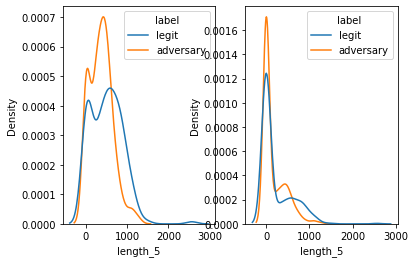

<Figure size 432x288 with 0 Axes>

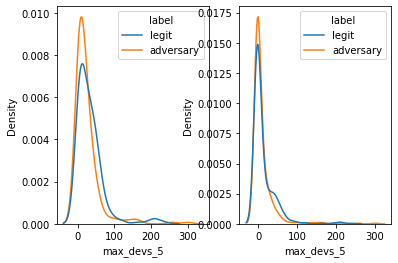

<Figure size 432x288 with 0 Axes>

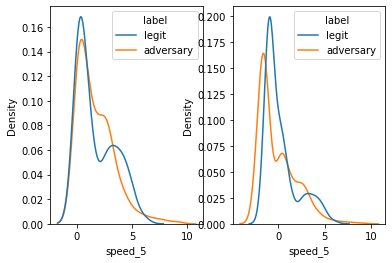

<Figure size 432x288 with 0 Axes>

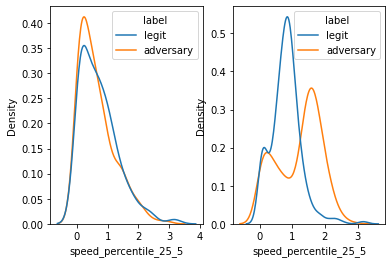

<Figure size 432x288 with 0 Axes>

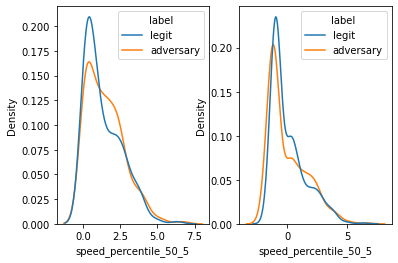

<Figure size 432x288 with 0 Axes>

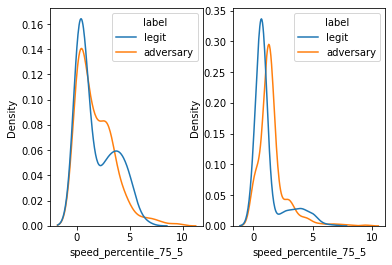

<Figure size 432x288 with 0 Axes>

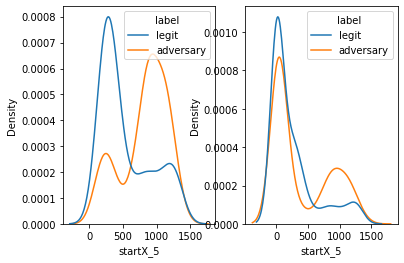

<Figure size 432x288 with 0 Axes>

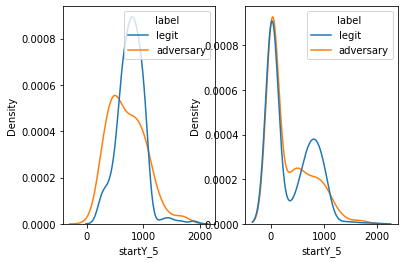

<Figure size 432x288 with 0 Axes>

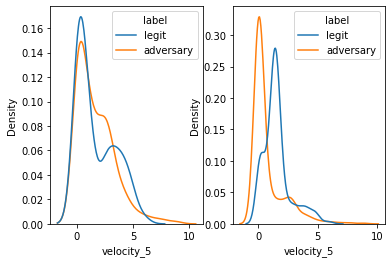

<Figure size 432x288 with 0 Axes>

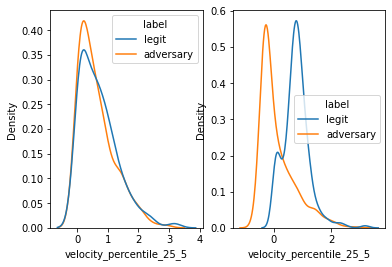

<Figure size 432x288 with 0 Axes>

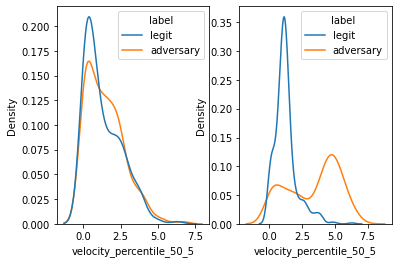

<Figure size 432x288 with 0 Axes>

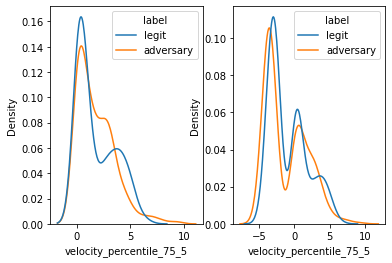

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_sns(1)